# Final Project

In [1]:
# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
import kagglehub
from urllib.parse import urlparse
from itertools import chain, combinations
from collections import Counter
import re

# Data Science Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Progress Tracking
from tqdm import tqdm

# Language Processing
from textblob import TextBlob
from datetime import datetime, timedelta
import string

# globals
random_state = 42

## Load Data and Summarize

### Dataset 1: Web Page Phishing Dectection

In [2]:
def load_Kaggle_dataset(kaggle_path, kaggle_filename, index_col=0):

    # Download latest version
    path = kagglehub.dataset_download(kaggle_path)
    print("Path to dataset files:", path)

    # Load the data into a DataFrame
    csv_path = os.path.join(path, kaggle_filename)
    raw_data = pd.read_csv(csv_path, index_col=index_col)

    return raw_data

In [3]:
# Load raw data from Kagglehub
phishing_webpage_raw = load_Kaggle_dataset('shashwatwork/web-page-phishing-detection-dataset', 'dataset_phishing.csv', index_col=None)

Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/shashwatwork/web-page-phishing-detection-dataset/versions/2


In [7]:
# Sample of data
phishing_webpage_raw.head()

url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                      1                        0   
1                1                      0                        0   
2                1                      0                        0   
3                1                      0                        0   
4                0                      1                        0   

   domain_registration_length  domain_age  web_traffic  dns_record  \
0                          45          -1            0           1   
1                          77        5767            0           0   
2                          14        4004      5828815           0   
3                          62          -1       107721           0   
4                         224        8175         8725           0   

   google_index  page_rank      status  
0             1          4  legitimate  
1             1          2    phishing  
2             1          0    phishing  
3             0          3  legitimate  
4             0          6  legitimate  

[5 rows x 89 columns]

In [8]:
# Summary of data types
phishing_webpage_raw.dtypes

url                object
length_url          int64
length_hostname     int64
ip                  int64
nb_dots             int64
                    ...  
web_traffic         int64
dns_record          int64
google_index        int64
page_rank           int64
status             object
Length: 89, dtype: object

In [9]:
# Overall summary of data row counts, means, standard deviation, min, max, and distibution
phishing_webpage_raw.describe()

length_url  length_hostname            ip       nb_dots  \
count  11430.000000     11430.000000  11430.000000  11430.000000   
mean      61.126684        21.090289      0.150569      2.480752   
std       55.297318        10.777171      0.357644      1.369686   
min       12.000000         4.000000      0.000000      1.000000   
25%       33.000000        15.000000      0.000000      2.000000   
50%       47.000000        19.000000      0.000000      2.000000   
75%       71.000000        24.000000      0.000000      3.000000   
max     1641.000000       214.000000      1.000000     24.000000   

         nb_hyphens         nb_at         nb_qm        nb_and    nb_or  \
count  11430.000000  11430.000000  11430.000000  11430.000000  11430.0   
mean       0.997550      0.022222      0.141207      0.162292      0.0   
std        2.087087      0.155500      0.364456      0.821337      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0   
25%        0.000000      0.000000      0.000000      0.000000      0.0   
50%        0.000000      0.000000      0.000000      0.000000      0.0   
75%        1.000000      0.000000      0.000000      0.000000      0.0   
max       43.000000      4.000000      3.000000     19.000000      0.0   

              nb_eq  ...   empty_title  domain_in_title  \
count  11430.000000  ...  11430.000000     11430.000000   
mean       0.293176  ...      0.124759         0.775853   
std        0.998317  ...      0.330460         0.417038   
min        0.000000  ...      0.000000         0.000000   
25%        0.000000  ...      0.000000         1.000000   
50%        0.000000  ...      0.000000         1.000000   
75%        0.000000  ...      0.000000         1.000000   
max       19.000000  ...      1.000000         1.000000   

       domain_with_copyright  whois_registered_domain  \
count           11430.000000             11430.000000   
mean                0.439545                 0.072878   
std                 0.496353                 0.259948   
min                 0.000000                 0.000000   
25%                 0.000000                 0.000000   
50%                 0.000000                 0.000000   
75%                 1.000000                 0.000000   
max                 1.000000                 1.000000   

       domain_registration_length    domain_age   web_traffic    dns_record  \
count                11430.000000  11430.000000  1.143000e+04  11430.000000   
mean                   492.532196   4062.543745  8.567566e+05      0.020122   
std                    814.769415   3107.784600  1.995606e+06      0.140425   
min                     -1.000000    -12.000000  0.000000e+00      0.000000   
25%                     84.000000    972.250000  0.000000e+00      0.000000   
50%                    242.000000   3993.000000  1.651000e+03      0.000000   
75%                    449.000000   7026.750000  3.738455e+05      0.000000   
max                  29829.000000  12874.000000  1.076799e+07      1.000000   

       google_index     page_rank  
count  11430.000000  11430.000000  
mean       0.533946      3.185739  
std        0.498868      2.536955  
min        0.000000      0.000000  
25%        0.000000      1.000000  
50%        1.000000      3.000000  
75%        1.000000      5.000000  
max        1.000000     10.000000  

[8 rows x 87 columns]

In [10]:
# Number of features
len(phishing_webpage_raw.columns)

89

### Dataset 2: Phishing Email Detection

In [4]:
# Load raw data from Kagglehub
phishing_email_raw = load_Kaggle_dataset("subhajournal/phishingemails", "Phishing_Email.csv")

Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/subhajournal/phishingemails/versions/1


In [12]:
# Sample of data
phishing_email_raw.head()

Email Text      Email Type
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email

In [13]:
# Summary of data types
phishing_email_raw.dtypes

Email Text    object
Email Type    object
dtype: object

In [14]:
# Overall summary of data row counts, unique values, top occuring elements and frequency
phishing_email_raw.describe()

Email Text  Email Type
count       18634       18650
unique      17537           2
top         empty  Safe Email
freq          533       11322

There looks to be missing values in this dataset because the count of the email text and email type are different. The frequency of safe emails is greater than the frequncy of phishing emails. There are 533 empty emails in the dataset.

In [15]:
# Number of features
len(phishing_email_raw.columns)

2

### Dataset 3: Cybersecurity Risk 2022

In [5]:
# Load raw data from Kagglehub
cyber_security_raw1 = load_Kaggle_dataset("thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne", "2022-06-08-enriched.csv", index_col=None)
cyber_security_raw2 = load_Kaggle_dataset("thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne", "2022-06-09-enriched.csv", index_col=None)
cyber_security_raw3 = load_Kaggle_dataset("thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne", "2022-06-27-enriched.csv", index_col=None)
cyber_security_raw4 = load_Kaggle_dataset("thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne", "2022-07-04-enriched.csv", index_col=None)
cyber_security_raw5 = load_Kaggle_dataset("thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne", "2022-12-09-enriched.csv", index_col=None)

cyber_security_raw = pd.concat([cyber_security_raw1, cyber_security_raw2, cyber_security_raw3, cyber_security_raw4, cyber_security_raw5],
                                axis=0,
                                ignore_index=True
                                )


Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne/versions/2
Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne/versions/2
Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne/versions/2
Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne/versions/2
Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/thedevastator/exploring-cybersecurity-risk-via-2022-cisa-vulne/versions/2


In [17]:
# Sample of data
cyber_security_raw.head()

cve_id vendor_project             product  \
0  CVE-2021-27104      accellion                 FTA   
1  CVE-2021-27102      accellion                 FTA   
2  CVE-2021-27101      accellion                 FTA   
3  CVE-2021-27103      accellion                 FTA   
4  CVE-2021-21017          adobe  Acrobat and Reader   

                                  vulnerability_name  date_added  \
0   Accellion FTA OS Command Injection Vulnerability  2021-11-03   
1   Accellion FTA OS Command Injection Vulnerability  2021-11-03   
2          Accellion FTA SQL Injection Vulnerability  2021-11-03   
3                   Accellion FTA SSRF Vulnerability  2021-11-03   
4  Adobe Acrobat and Reader Heap-based Buffer Ove...  2021-11-03   

                                   short_description  \
0  Accellion FTA 9_12_370 and earlier is affected...   
1  Accellion FTA 9_12_411 and earlier is affected...   
2  Accellion FTA 9_12_370 and earlier is affected...   
3  Accellion FTA 9_12_411 and earlier is affected...   
4  Acrobat Reader DC versions versions 2020.013.2...   

                          required_action    due_date notes  grp    pub_date  \
0  Apply updates per vendor instructions.  2021-11-17   NaN    1  2021-02-16   
1  Apply updates per vendor instructions.  2021-11-17   NaN    1  2021-02-16   
2  Apply updates per vendor instructions.  2021-11-17   NaN    1  2021-02-16   
3  Apply updates per vendor instructions.  2021-11-17   NaN    1  2021-02-16   
4  Apply updates per vendor instructions.  2021-11-17   NaN    1  2021-02-11   

   cvss      cwe   vector complexity  severity  
0   9.8   CWE-78  NETWORK        LOW  CRITICAL  
1   7.8   CWE-78    LOCAL        LOW      HIGH  
2   9.8   CWE-89  NETWORK        LOW  CRITICAL  
3   9.8  CWE-918  NETWORK        LOW  CRITICAL  
4   8.8  CWE-787  NETWORK        LOW      HIGH

In [18]:
# Summary of data types
cyber_security_raw.dtypes

cve_id                 object
vendor_project         object
product                object
vulnerability_name     object
date_added             object
short_description      object
required_action        object
due_date               object
notes                  object
grp                     int64
pub_date               object
cvss                  float64
cwe                    object
vector                 object
complexity             object
severity               object
dtype: object

The python method pd.df.describe() will not be used with this dataset in the raw format because there are too many object type columns.

In [19]:
vendors = len(cyber_security_raw['vendor_project'].unique())
print(f'There are {vendors} unique vendor names.')

There are 140 unique vendor names.


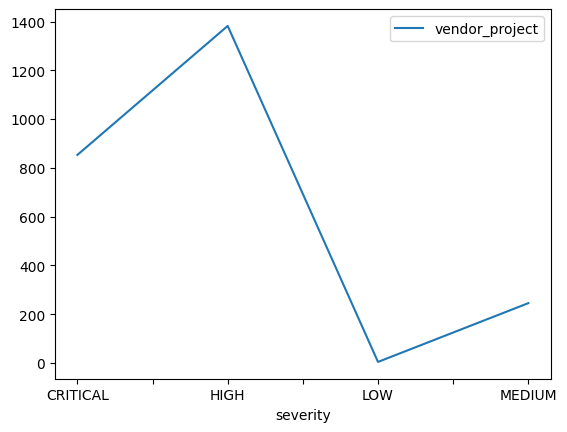

In [20]:
cyber_security_raw[['vendor_project', 'severity']].groupby('severity').count().plot()
None

### Dataset 4: Credit Card Transactions Fraud Detection Dataset

In [6]:
# Load raw data from Kagglehub
credit_card_raw1 = load_Kaggle_dataset("kartik2112/fraud-detection", "fraudTest.csv")
credit_card_raw2 = load_Kaggle_dataset("kartik2112/fraud-detection", "fraudTrain.csv")

credit_card_raw = pd.concat([credit_card_raw1, credit_card_raw2],
                            axis=0,
                            ignore_index=True
                            )

Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1
Path to dataset files: /Users/rosemarydabbs/.cache/kagglehub/datasets/kartik2112/fraud-detection/versions/1


In [22]:
credit_card_raw.head()

trans_date_trans_time            cc_num  \
0   2020-06-21 12:14:25  2291163933867244   
1   2020-06-21 12:14:33  3573030041201292   
2   2020-06-21 12:14:53  3598215285024754   
3   2020-06-21 12:15:15  3591919803438423   
4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street        city  ...      lat  \
0   Elliott      M            351 Darlene Green    Columbia  ...  33.9659   
1  Williams      F             3638 Marsh Union     Altonah  ...  40.3207   
2     Lopez      F         9333 Valentine Point    Bellmore  ...  40.6729   
3  Williams      M  32941 Krystal Mill Apt. 552  Titusville  ...  28.5697   
4    Massey      M     5783 Evan Roads Apt. 465    Falmouth  ...  44.2529   

       long  city_pop                     job         dob  \
0  -80.9355    333497     Mechanical engineer  1968-03-19   
1 -110.4360       302  Sales professional, IT  1990-01-17   
2  -73.5365     34496       Librarian, public  1970-10-21   
3  -80.8191     54767            Set designer  1987-07-25   
4  -85.0170      1126      Furniture designer  1955-07-06   

                          trans_num   unix_time  merch_lat  merch_long  \
0  2da90c7d74bd46a0caf3777415b3ebd3  1371816865  33.986391  -81.200714   
1  324cc204407e99f51b0d6ca0055005e7  1371816873  39.450498 -109.960431   
2  c81755dbbbea9d5c77f094348a7579be  1371816893  40.495810  -74.196111   
3  2159175b9efe66dc301f149d3d5abf8c  1371816915  28.812398  -80.883061   
4  57ff021bd3f328f8738bb535c302a31b  1371816917  44.959148  -85.884734   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 22 columns]

In [23]:
credit_card_raw.describe()

cc_num           amt           zip           lat          long  \
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06   
mean   4.173860e+17  7.006357e+01  4.881326e+04  3.853931e+01 -9.022783e+01   
std    1.309115e+18  1.592540e+02  2.688185e+04  5.071470e+00  1.374789e+01   
min    6.041621e+10  1.000000e+00  1.257000e+03  2.002710e+01 -1.656723e+02   
25%    1.800429e+14  9.640000e+00  2.623700e+04  3.466890e+01 -9.679800e+01   
50%    3.521417e+15  4.745000e+01  4.817400e+04  3.935430e+01 -8.747690e+01   
75%    4.642255e+15  8.310000e+01  7.204200e+04  4.194040e+01 -8.015800e+01   
max    4.992346e+18  2.894890e+04  9.992100e+04  6.669330e+01 -6.795030e+01   

           city_pop     unix_time     merch_lat    merch_long      is_fraud  
count  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  1.852394e+06  
mean   8.864367e+04  1.358674e+09  3.853898e+01 -9.022794e+01  5.210015e-03  
std    3.014876e+05  1.819508e+07  5.105604e+00  1.375969e+01  7.199217e-02  
min    2.300000e+01  1.325376e+09  1.902742e+01 -1.666716e+02  0.000000e+00  
25%    7.410000e+02  1.343017e+09  3.474012e+01 -9.689944e+01  0.000000e+00  
50%    2.443000e+03  1.357089e+09  3.936890e+01 -8.744069e+01  0.000000e+00  
75%    2.032800e+04  1.374581e+09  4.195626e+01 -8.024511e+01  0.000000e+00  
max    2.906700e+06  1.388534e+09  6.751027e+01 -6.695090e+01  1.000000e+00

In [24]:
credit_card_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [25]:
# Number of features
len(credit_card_raw.columns)

22

## Preprocessing

### Dataset 1: Web Page Phishing Detection

In [26]:
# Check for null values
web_nulls = phishing_webpage_raw.isnull().sum().sum()

if web_nulls == 0:
    print('No missing values found.')
else:
    print(f'There are {web_nulls} missing data fields in the dataset.')

No missing values found.


In [27]:
# Check for duplicates
web_duplicates = phishing_webpage_raw.duplicated().sum()

if web_duplicates == 0:
    print('No duplicates found.')
else:
    print(f'There are {web_duplicates} duplicates in the dataset.')

No duplicates found.


In [28]:
count_neg_ones = (phishing_webpage_raw == -1).sum().sum()
print(f'There are {count_neg_ones} values equal to -1.')

There are 1827 values equal to -1.


In [29]:
# Make copy before making changes
phishing_webpage = phishing_webpage_raw.copy()

In [30]:
# Replace -1 values with 0
phishing_webpage.replace(-1, 0, inplace=True)

In [31]:
# Check to see if replace worked
if (phishing_webpage == -1).sum().sum() == 0:
    print('Success!')
else:
    print('Try again. There are still -1 values.')

Success!


In [32]:
# Calculate mean, median, and mode for numeric values
web_means = phishing_webpage.mean(numeric_only=True)

web_medians = phishing_webpage.median(numeric_only=True)

web_modes = phishing_webpage.mode(numeric_only=True).iloc[0]


In [33]:
print('Means for the Data by Column')
print(web_means)

Means for the Data by Column
length_url             61.126684
length_hostname        21.090289
ip                      0.150569
nb_dots                 2.480752
nb_hyphens              0.997550
                       ...      
domain_age           4062.699563
web_traffic        856756.643307
dns_record              0.020122
google_index            0.533946
page_rank               3.185739
Length: 87, dtype: float64


In [34]:
print('Medians for the Data by Column')
print(web_medians)

Medians for the Data by Column
length_url           47.0
length_hostname      19.0
ip                    0.0
nb_dots               2.0
nb_hyphens            0.0
                    ...  
domain_age         3993.0
web_traffic        1651.0
dns_record            0.0
google_index          1.0
page_rank             3.0
Length: 87, dtype: float64


In [35]:
print('Modes for the Data by Column')
print(web_modes)

Modes for the Data by Column
length_url         26.0
length_hostname    16.0
ip                  0.0
nb_dots             2.0
nb_hyphens          0.0
                   ... 
domain_age          0.0
web_traffic         0.0
dns_record          0.0
google_index        1.0
page_rank           0.0
Name: 0, Length: 87, dtype: float64


In [36]:
# Encode status column
one_hot = pd.get_dummies(phishing_webpage["status"])
phishing_webpage_encoded = phishing_webpage.join(one_hot).copy()

# Convert to integers
phishing_webpage_encoded[['legitimate','phishing']] = phishing_webpage_encoded[['legitimate','phishing']].astype(int)

# Remove extra columns
phishing_webpage_encoded = phishing_webpage_encoded.drop(columns=['status', 'phishing'])
# 1 = Legitimate
# 0 = phishing

# Check to see if encoding worked
phishing_webpage_encoded.iloc[0:5]

url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                      1                        0   
1                1                      0                        0   
2                1                      0                        0   
3                1                      0                        0   
4                0                      1                        0   

   domain_registration_length  domain_age  web_traffic  dns_record  \
0                          45           0            0           1   
1                          77        5767            0           0   
2                          14        4004      5828815           0   
3                          62           0       107721           0   
4                         224        8175         8725           0   

   google_index  page_rank  legitimate  
0             1          4           1  
1             1          2           0  
2             1          0           0  
3             0          3           1  
4             0          6           1  

[5 rows x 89 columns]

In [37]:
# Cleaned version for modeling
df_webpage = phishing_webpage_encoded.drop(columns=['url'])

In [38]:
# Manually select interesting features to simplify preliminary univariant and bivariant analysis
url_features = ['url', 
                'length_url', 
                'length_hostname',
                'ip',
                'nb_dots',
                'nb_hyphens',
                'nb_at',
                'nb_qm',
                'nb_and',
                'nb_or',
                'nb_eq',
                'nb_underscore',
                'nb_tilde',
                'nb_percent',
                'nb_slash',
                'nb_star',
                'nb_colon',
                'nb_comma',
                'nb_semicolumn',
                'nb_dollar',
                'https_token',
                'ratio_digits_url',
                'ratio_digits_host',
                'nb_redirection',
                'char_repeat',
                'legitimate']
phishing_webpage_filtered = phishing_webpage_encoded[url_features]

In [39]:
phishing_webpage_filtered.describe()

length_url  length_hostname            ip       nb_dots  \
count  11430.000000     11430.000000  11430.000000  11430.000000   
mean      61.126684        21.090289      0.150569      2.480752   
std       55.297318        10.777171      0.357644      1.369686   
min       12.000000         4.000000      0.000000      1.000000   
25%       33.000000        15.000000      0.000000      2.000000   
50%       47.000000        19.000000      0.000000      2.000000   
75%       71.000000        24.000000      0.000000      3.000000   
max     1641.000000       214.000000      1.000000     24.000000   

         nb_hyphens         nb_at         nb_qm        nb_and    nb_or  \
count  11430.000000  11430.000000  11430.000000  11430.000000  11430.0   
mean       0.997550      0.022222      0.141207      0.162292      0.0   
std        2.087087      0.155500      0.364456      0.821337      0.0   
min        0.000000      0.000000      0.000000      0.000000      0.0   
25%        0.000000      0.000000      0.000000      0.000000      0.0   
50%        0.000000      0.000000      0.000000      0.000000      0.0   
75%        1.000000      0.000000      0.000000      0.000000      0.0   
max       43.000000      4.000000      3.000000     19.000000      0.0   

              nb_eq  ...      nb_colon      nb_comma  nb_semicolumn  \
count  11430.000000  ...  11430.000000  11430.000000   11430.000000   
mean       0.293176  ...      1.027909      0.004024       0.062292   
std        0.998317  ...      0.240325      0.103240       0.598190   
min        0.000000  ...      1.000000      0.000000       0.000000   
25%        0.000000  ...      1.000000      0.000000       0.000000   
50%        0.000000  ...      1.000000      0.000000       0.000000   
75%        0.000000  ...      1.000000      0.000000       0.000000   
max       19.000000  ...      7.000000      4.000000      20.000000   

          nb_dollar   https_token  ratio_digits_url  ratio_digits_host  \
count  11430.000000  11430.000000      11430.000000       11430.000000   
mean       0.001925      0.610936          0.053137           0.025024   
std        0.077111      0.487559          0.089363           0.093422   
min        0.000000      0.000000          0.000000           0.000000   
25%        0.000000      0.000000          0.000000           0.000000   
50%        0.000000      1.000000          0.000000           0.000000   
75%        0.000000      1.000000          0.079365           0.000000   
max        6.000000      1.000000          0.723881           0.800000   

       nb_redirection   char_repeat    legitimate  
count    11430.000000  11430.000000  11430.000000  
mean         0.498250      2.927472      0.500000  
std          0.691907      4.768936      0.500022  
min          0.000000      0.000000      0.000000  
25%          0.000000      1.000000      0.000000  
50%          0.000000      3.000000      0.500000  
75%          1.000000      4.000000      1.000000  
max          6.000000    146.000000      1.000000  

[8 rows x 25 columns]

### Dataset 2: Phishing Email Detection

In [40]:
# Create copy before preprocessing
phishing_email = phishing_email_raw.copy()

In [41]:
# Convert Email Text column to string type
phishing_email['Email Text'] = phishing_email['Email Text'].astype('string')

if phishing_email['Email Text'].dtype == 'string':
    print('Sucess!')
else:
    print('Failure.')

Sucess!


In [42]:
# One-hot encode Email Type column for modeling prep
one_hot = pd.get_dummies(phishing_email['Email Type'])
phishing_email_encoded = phishing_email.join(one_hot).copy()

# Convert to binary integers
phishing_email_encoded[['Phishing Email', 'Safe Email']] = phishing_email_encoded[['Phishing Email', 'Safe Email']].astype(int)

# Remove extra columns
phishing_email_encoded = phishing_email_encoded.drop(columns=['Email Type', 'Phishing Email'])
# 1 = Safe Email
# 0 = Phishing Email

# Show Results
phishing_email_encoded.iloc[0:5]

Email Text  Safe Email
0  re : 6 . 1100 , disc : uniformitarianism , re ...           1
1  the other side of * galicismos * * galicismo *...           1
2  re : equistar deal tickets are you still avail...           1
3  
Hello I am your hot lil horny toy.
    I am t...           0
4  software at incredibly low prices ( 86 % lower...           0

In [43]:
# Check for missing values
phishing_email_encoded.isnull().sum()

Email Text    16
Safe Email     0
dtype: int64

In [44]:
# Remove missing values
phishing_email_cleaned = phishing_email_encoded.dropna()

# Check to see if cleaning was a success
if phishing_email_cleaned.isnull().sum().sum() == 0:
    print('Null values successfully removed.')
else:
    print('Unsuccessul. Null values remain.')

Null values successfully removed.


In [45]:
# Check for duplicated values
phishing_email_cleaned['Email Text'].is_unique

False

Since the "empty" emails will be flagged as duplicates. I will remove them, then remove the duplicates, and then add the empty emails back in.

In [46]:
# Save empty emails to a separate dataframe
empty_emails = phishing_email_cleaned.query("`Email Text` == 'empty'")

In [47]:
# Check for duplicates that are not empty
check_duplicates = phishing_email_cleaned[phishing_email_cleaned.duplicated(keep='first')].query("`Email Text` != 'empty'")
print(f'There are a total of {len(check_duplicates)} duplicates that were found.')

There are a total of 565 duplicates that were found.


In [48]:
# Filter out the empty emails and drop duplicates
no_duplicated_emails = phishing_email_cleaned.query("`Email Text` != 'empty'").drop_duplicates()

# Check how many duplicates remain
if no_duplicated_emails.duplicated().sum() == 0:
    print('Sucess!')
else:
    print('Failure.')

Sucess!


In [49]:
# Add the empty email back to the dataset
phishing_email_cleaned = pd.concat([no_duplicated_emails, empty_emails], axis=0)

In [50]:
# Make sure everything worked
if phishing_email_cleaned.duplicated(keep=False).sum() == len(empty_emails):
    print('Only empty duplicates remain. Success!')
else:
    print('Review duplicated rows. Failure.')

Only empty duplicates remain. Success!


Adding Features:

In [51]:
def extract_email_features(text):
    features = {}
    text_lower = text.lower()

    # Sentiment Analysis
    blob = TextBlob(text)
    sentiment = blob.sentiment
    features['polarity'] = sentiment.polarity
    features['subjectivity'] = sentiment.subjectivity

    # Count Unique Words
    features['unique_words'] = len(set(text_lower.translate(str.maketrans('', '', string.punctuation)).split()))

    # Basic text features
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['uppercase_ratio'] = sum(1 for c in text if c.isupper()) / (len(text) + 1e-5)
    features['symbol_ratio'] = sum(1 for c in text if c in string.punctuation) / (len(text) + 1e-5)

    # Keyword-based features
    fraud_keywords = ['urgent', 'verify', 'account', 'click', 'suspend', 'update', 'login', 'confirm']
    keyword_counts = Counter([kw for kw in fraud_keywords if kw in text_lower])
    features.update({f'kw_{kw}': keyword_counts.get(kw, 0) for kw in fraud_keywords})

    # Regex-based extraction
    currency_symbols = re.findall(r'[$€₿]', text)
    features['currency_symbol_count'] = len(currency_symbols)

    phone_matches = re.findall(r'\+?\d[\d\s\-]{7,}\d', text)
    features['phone_number_count'] = len(phone_matches)

    return features

In [52]:
# Apply the feature extraction function to each email
feature_df = phishing_email_cleaned['Email Text'].apply(extract_email_features).apply(pd.Series)

# Combine the new features with the original DataFrame
df_phishing_email = pd.concat([phishing_email_cleaned, feature_df], axis=1)

In [53]:
# Move target column to end
col_to_move = 'Safe Email'
df_phishing_email = df_phishing_email[[c for c in df_phishing_email.columns if c != col_to_move] + [col_to_move]]

In [54]:
df_phishing_email.head()

Email Text  polarity  subjectivity  \
0  re : 6 . 1100 , disc : uniformitarianism , re ...  0.201493      0.514213   
1  the other side of * galicismos * * galicismo *...  0.009375      0.084375   
2  re : equistar deal tickets are you still avail...  0.091540      0.515783   
3  
Hello I am your hot lil horny toy.
    I am t...  0.260069      0.690278   
4  software at incredibly low prices ( 86 % lower...  0.152579      0.505258   

   unique_words  char_count  word_count  uppercase_ratio  symbol_ratio  \
0         110.0      1030.0       230.0         0.000000      0.059223   
1          53.0       479.0        91.0         0.000000      0.037578   
2         102.0      1245.0       305.0         0.000000      0.077108   
3          73.0       688.0        96.0         0.056686      0.162791   
4          60.0       441.0        91.0         0.000000      0.061224   

   kw_urgent  kw_verify  kw_account  kw_click  kw_suspend  kw_update  \
0        0.0        0.0         0.0       0.0         0.0        0.0   
1        0.0        0.0         0.0       0.0         0.0        0.0   
2        0.0        0.0         0.0       0.0         0.0        0.0   
3        0.0        0.0         0.0       0.0         0.0        0.0   
4        0.0        0.0         0.0       0.0         0.0        0.0   

   kw_login  kw_confirm  currency_symbol_count  phone_number_count  Safe Email  
0       0.0         0.0                    0.0                 0.0           1  
1       0.0         0.0                    0.0                 0.0           1  
2       0.0         0.0                    0.0                 0.0           1  
3       0.0         0.0                    0.0                 3.0           0  
4       0.0         0.0                    0.0                 0.0           0

In [55]:
df_phishing_email.dtypes

Email Text               string[python]
polarity                        float64
subjectivity                    float64
unique_words                    float64
char_count                      float64
word_count                      float64
uppercase_ratio                 float64
symbol_ratio                    float64
kw_urgent                       float64
kw_verify                       float64
kw_account                      float64
kw_click                        float64
kw_suspend                      float64
kw_update                       float64
kw_login                        float64
kw_confirm                      float64
currency_symbol_count           float64
phone_number_count              float64
Safe Email                        int64
dtype: object

In [56]:
# Cleaned version for modeling
df_email = df_phishing_email.drop(columns=['Email Text'])

### Dataset 3: Credit Card Transactions Fraud Detection Dataset

In [57]:
# Check for missing values
credit_card_raw.isnull().sum().sum()

0

In [58]:
# Check for duplicates
check_duplicates_ccd = credit_card_raw[credit_card_raw.duplicated(keep='first')]
print(f'There are a total of {len(check_duplicates_ccd)} duplicates that were found.')

There are a total of 0 duplicates that were found.


In [59]:
# Create copy before preprocessing
credit_card = credit_card_raw.copy()

In [60]:
# Change to date-time format
credit_card['trans_date_trans_time'] = pd.to_datetime(credit_card['trans_date_trans_time'], format="%Y-%m-%d %H:%M:%S")

Adding Features:

In [61]:
# Add age feature
credit_card['dob'] = pd.to_datetime(credit_card_raw['dob'], format="%Y-%m-%d")
credit_card['age'] = (pd.to_datetime("today") - credit_card['dob']).dt.days // 365

In [62]:
# Add feature representing max repeating digits for each ccd number

# Function to get max digit count
def max_repeating_digits(n):
    digit_counts = Counter(str(n))
    return max(digit_counts.values())

# Apply to the column
credit_card['max_repeats'] = credit_card['cc_num'].apply(max_repeating_digits)

In [63]:
credit_card.dtypes

trans_date_trans_time    datetime64[ns]
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
age                               int64
max_repeats                       int64
dtype: object

In [64]:
# Label categorical columns
credit_card['category'], _ = pd.factorize(credit_card['category'])
credit_card['city'], _ = pd.factorize(credit_card['city'])
credit_card['state'], _ = pd.factorize(credit_card['state'])
credit_card['gender'], _ = pd.factorize(credit_card['gender'])
credit_card['job'], _ = pd.factorize(credit_card['job'])


In [65]:
# Drop features before modeling
credit_card_drop = credit_card.drop(columns=['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'zip', 'dob', 'trans_num'])

In [66]:
# Move target column to end
col_to_move = 'is_fraud'
df_credit_card = credit_card_drop[[c for c in credit_card_drop.columns if c != col_to_move] + [col_to_move]]

In [67]:
# Cleaned version for modeling
df_credit_card.head()

category    amt  gender  city  state      lat      long  city_pop  job  \
0         0   2.86       0     0      0  33.9659  -80.9355    333497    0   
1         0  29.84       1     1      1  40.3207 -110.4360       302    1   
2         1  41.28       1     2      2  40.6729  -73.5365     34496    2   
3         2  60.05       0     3      3  28.5697  -80.8191     54767    3   
4         3   3.19       0     4      4  44.2529  -85.0170      1126    4   

    unix_time  merch_lat  merch_long  age  max_repeats  is_fraud  
0  1371816865  33.986391  -81.200714   57            3         0  
1  1371816873  39.450498 -109.960431   35            4         0  
2  1371816893  40.495810  -74.196111   54            4         0  
3  1371816915  28.812398  -80.883061   37            4         0  
4  1371816917  44.959148  -85.884734   69            3         0

In [70]:
df_credit_card.dtypes

category         int64
amt            float64
gender           int64
city             int64
state            int64
lat            float64
long           float64
city_pop         int64
job              int64
unix_time        int64
merch_lat      float64
merch_long     float64
age              int64
max_repeats      int64
is_fraud         int64
dtype: object

## Univariant Analysis

### Dataset 1: Web Page Phishing Detection

In [75]:
phishing_webpage_features = phishing_webpage_filtered.drop(columns=['url', 'legitimate'], inplace=False)

In [76]:
phishing_webpage_target = phishing_webpage_filtered[['legitimate']]

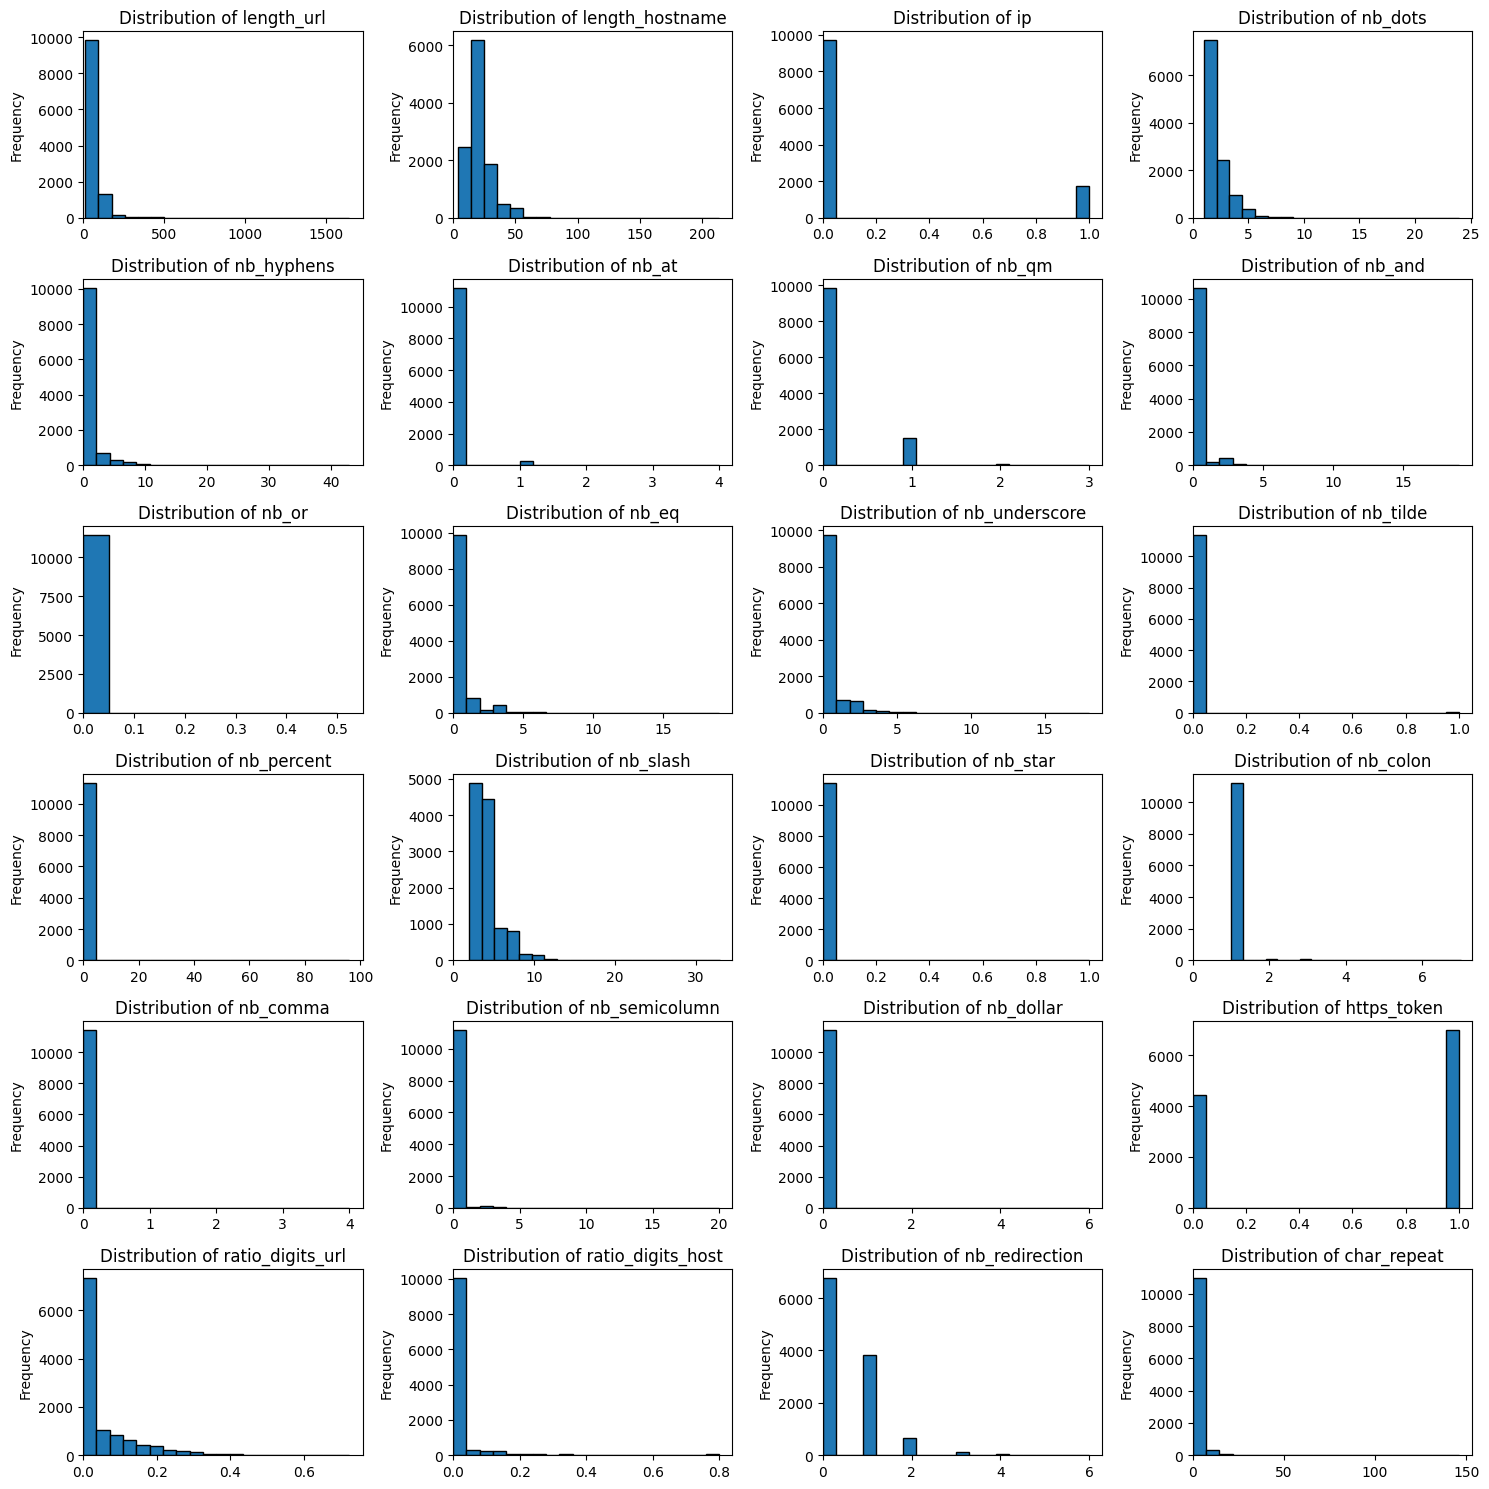

In [77]:
# Create a figure with subplots (6 rows x 4 columns for 24 histograms)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature (column) and plot its histogram
for i, column in enumerate(phishing_webpage_features.columns):
    axes[i].hist(phishing_webpage_features[column], bins=20, edgecolor='black')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlim(left=0)
    axes[i].set_ylim(bottom=0)

# Display plots
plt.tight_layout()
plt.show()


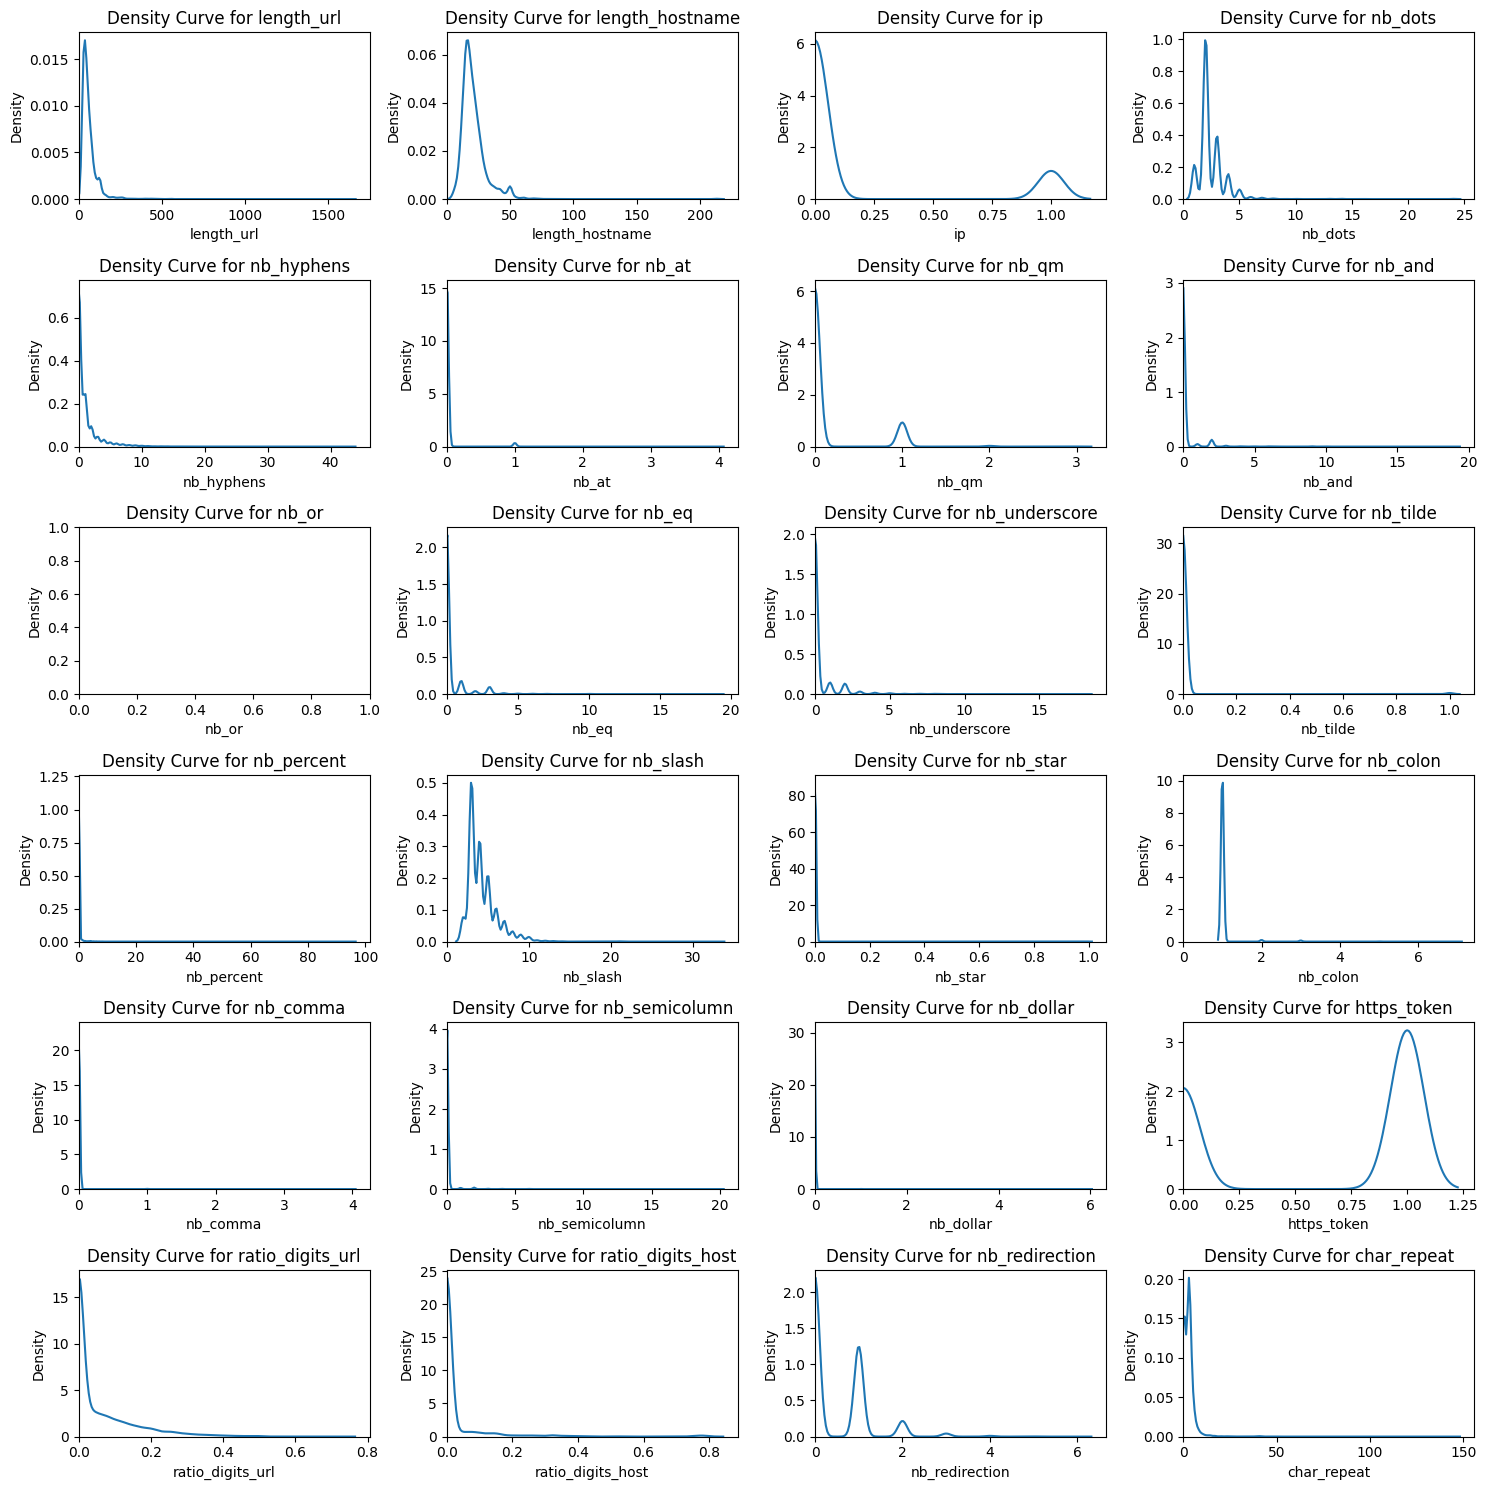

In [78]:
# Create a figure with subplots (6 rows x 4 columns for 24 histograms)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature (column) and plot its histogram
for i, column in enumerate(phishing_webpage_features.columns):
    sns.kdeplot(phishing_webpage_features[column], ax=axes[i], warn_singular=False)
    axes[i].set_title(f'Density Curve for {column}')
    axes[i].set_ylabel('Density')
    axes[i].set_xlim(left=0)
    axes[i].set_ylim(bottom=0)

# Display plots
plt.tight_layout()
plt.show()


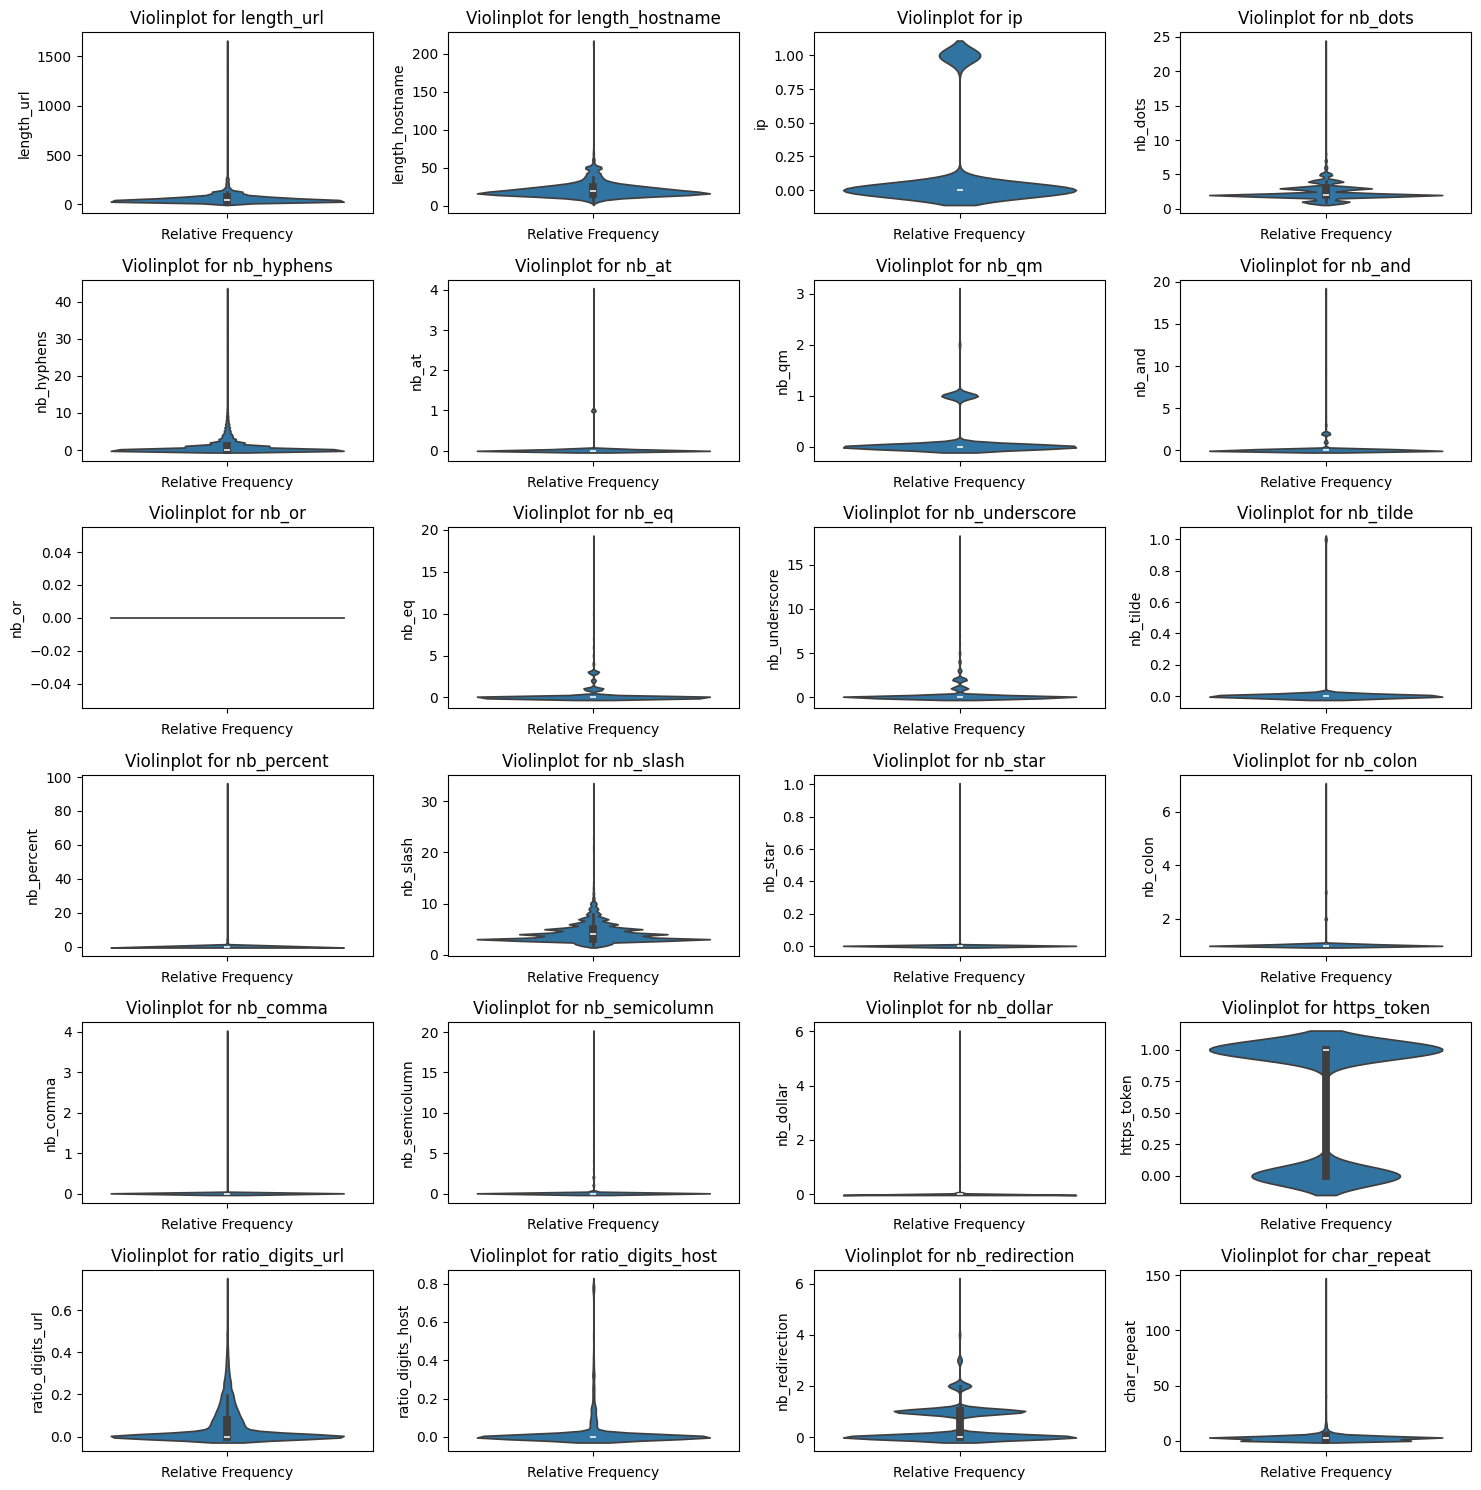

In [79]:
# Create a figure with subplots (6 rows x 4 columns for 24 histograms)
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each feature (column) and plot its histogram
for i, column in enumerate(phishing_webpage_features.columns):
    sns.violinplot(phishing_webpage_features[column], ax=axes[i])
    axes[i].set_title(f'Violinplot for {column}')
    axes[i].set_xlabel('Relative Frequency')

# Display plots
plt.tight_layout()
plt.show()

In [80]:
# Let explore the length of url and length of hostname after removing some 
# outliers since the outliers are "squishing" the distribution to the left bin.

# What is the max?
phishing_webpage_features['length_url'].max()

1641

In [81]:
# Remove some outliers to explore the more common URL lengths
df_filtered = phishing_webpage_features[["length_url"]].query('length_url < 200')

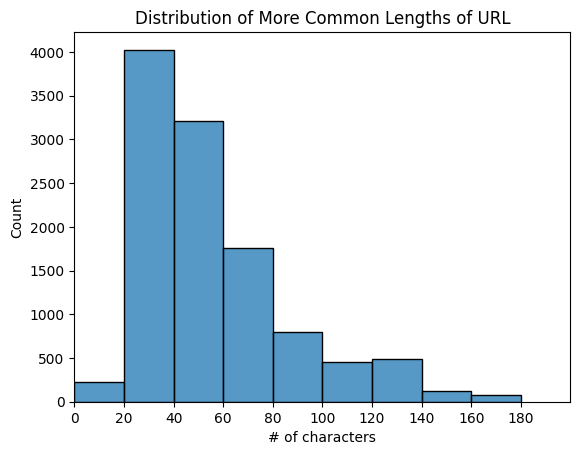

In [82]:
# Plot more common url lengths
bins = list(range(0, 200, 20))
sns.histplot(df_filtered['length_url'], bins=bins)
plt.title('Distribution of More Common Lengths of URL')
plt.xlabel('# of characters')
plt.xlim(0, 200)
plt.xticks(bins)
None

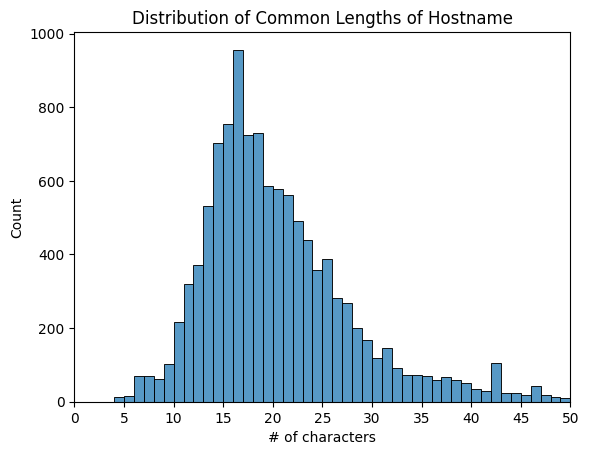

In [83]:
# Remove some outliers to explore the more common hostname lengths
hostname_length_filtered = phishing_webpage_features[["length_hostname"]].query('length_hostname < 50')

# Create histogram
bins = list(range(51))
sns.histplot(hostname_length_filtered['length_hostname'], bins=bins)
plt.title('Distribution of Common Lengths of Hostname')
plt.xlabel('# of characters')
plt.xticks(list(range(0, 51, 5)))
plt.xlim(0, 50)
None

In [84]:
# Filter data to look at less common lengths
url_length_filtered_uncommon = phishing_webpage_features[["length_url"]].query('length_url > 200')
hostname_length_filtered_uncommon = phishing_webpage_features[["length_hostname"]].query('length_hostname > 50')

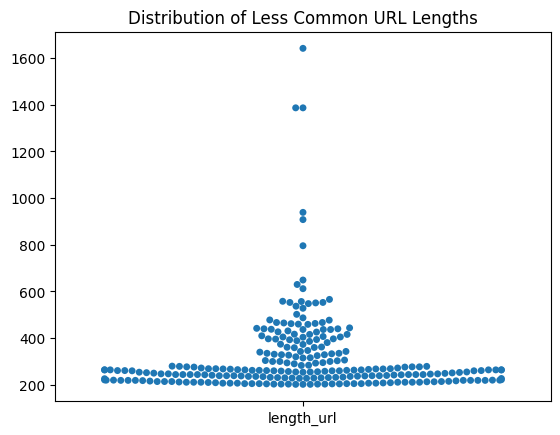

In [85]:
sns.swarmplot(url_length_filtered_uncommon)
plt.title('Distribution of Less Common URL Lengths')
None

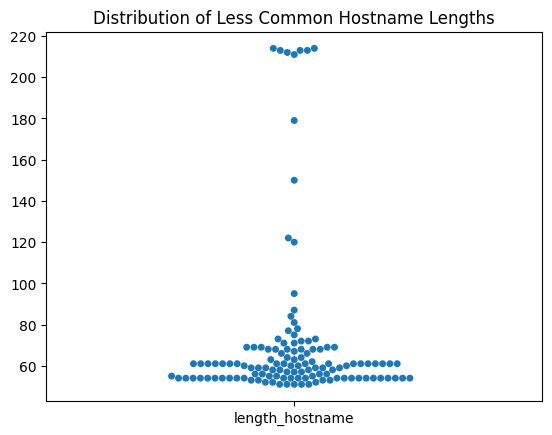

In [86]:
sns.swarmplot(hostname_length_filtered_uncommon)
plt.title('Distribution of Less Common Hostname Lengths')
None

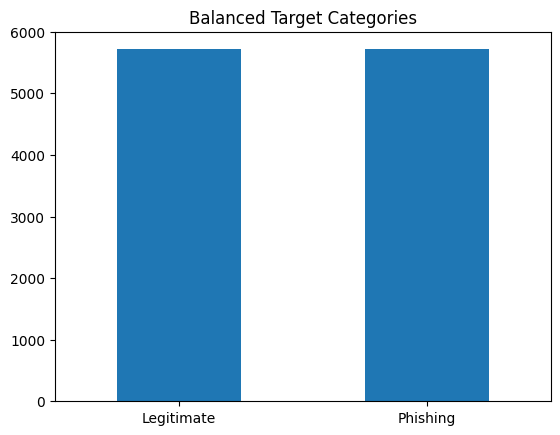

In [87]:
# Look at distribution of target
phishing_webpage_target['legitimate'].value_counts().plot.bar()
plt.title('Balanced Target Categories')
plt.xlabel(None)
plt.xticks(ticks=[0, 1], labels=['Legitimate', 'Phishing'], rotation=0)
None

### Dataset 2: Phishing Email Detection

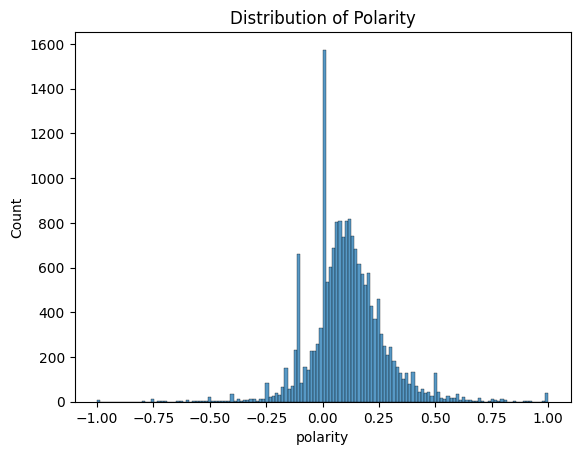

In [88]:
sns.histplot(df_email['polarity'])
plt.title("Distribution of Polarity")
None

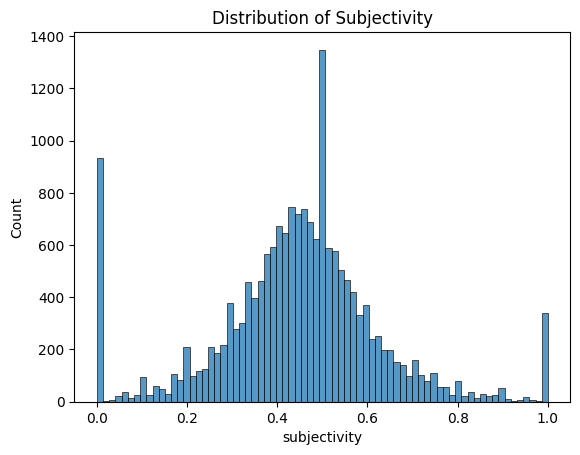

In [89]:
sns.histplot(df_email['subjectivity'])
plt.title("Distribution of Subjectivity")
None

In [90]:
df_email['unique_words'].max()

64134.0

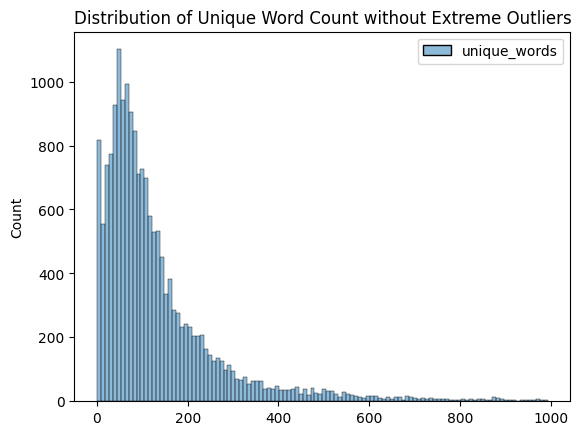

In [91]:
sns.histplot(df_email[['unique_words']].query('unique_words < 1000'))
plt.title("Distribution of Unique Word Count without Extreme Outliers")
None

### Dataset 3: Credit Card Transactions Fraud Detection Dataset

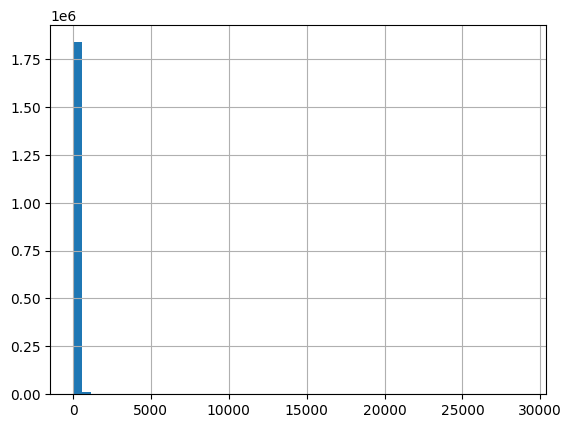

In [92]:
_ = credit_card['amt'].hist(bins=50)

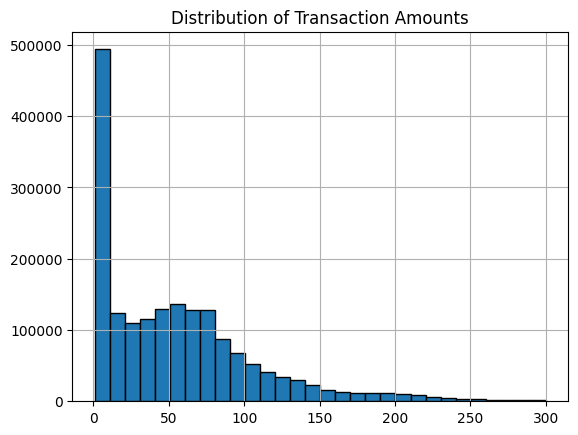

In [93]:
credit_card.query("amt < 300")['amt'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Transaction Amounts')
None

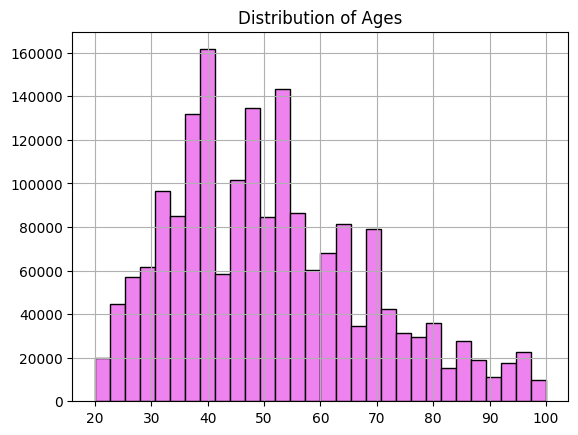

In [94]:
credit_card['age'].hist(bins=30, edgecolor='black', color='violet')
plt.title('Distribution of Ages')
None

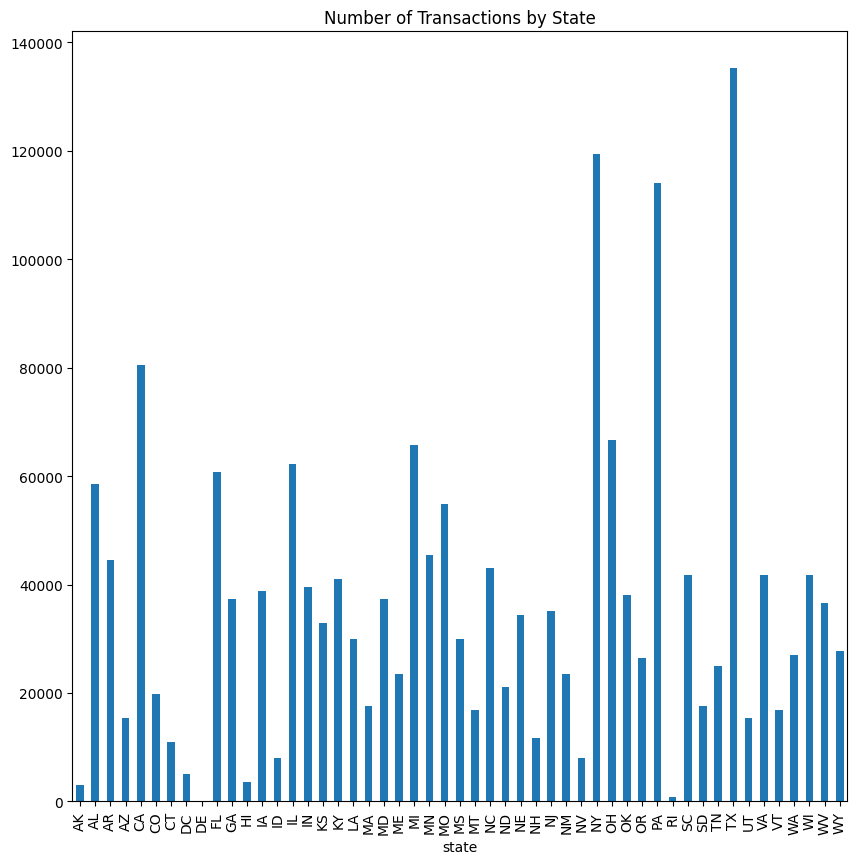

In [95]:
bystate = credit_card_raw.groupby('state')['trans_date_trans_time'].count()
bystate.plot.bar(figsize=(10, 10), legend=False)
plt.title('Number of Transactions by State')
None

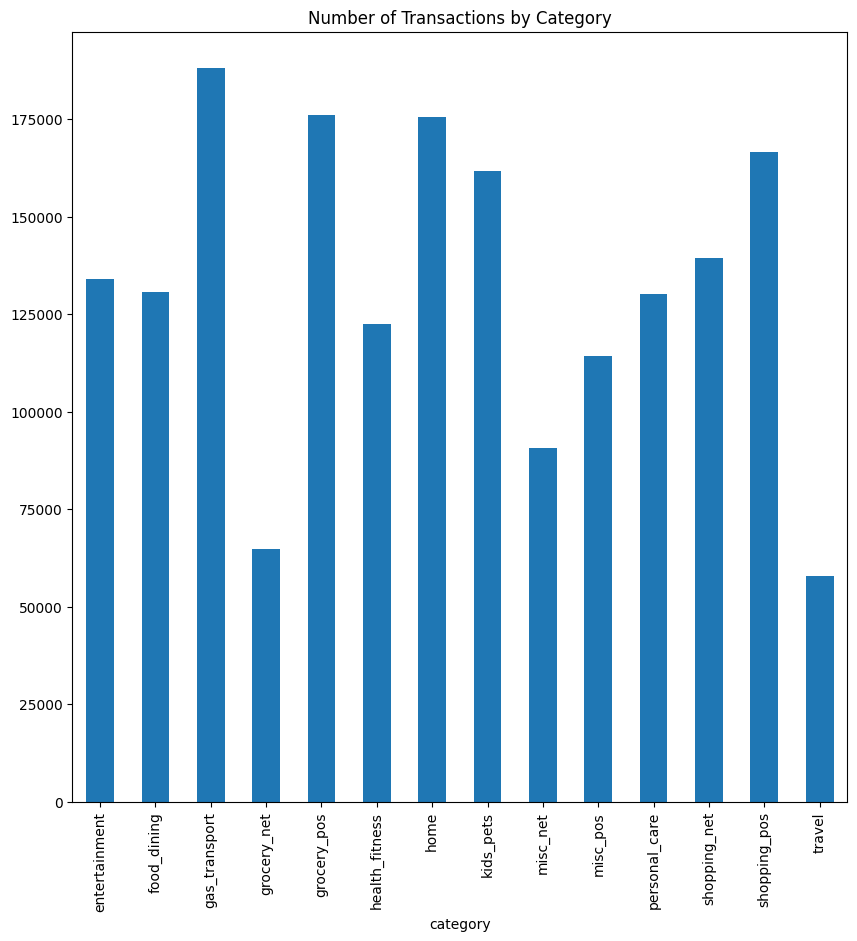

In [96]:
bycategory = credit_card_raw.groupby('category').count()[['trans_date_trans_time']]
bycategory.plot.bar(figsize=(10, 10), legend=False)
plt.title('Number of Transactions by Category')
None

## Bivariant Analysis

### Dataset 1: Web Page Phishing Detection

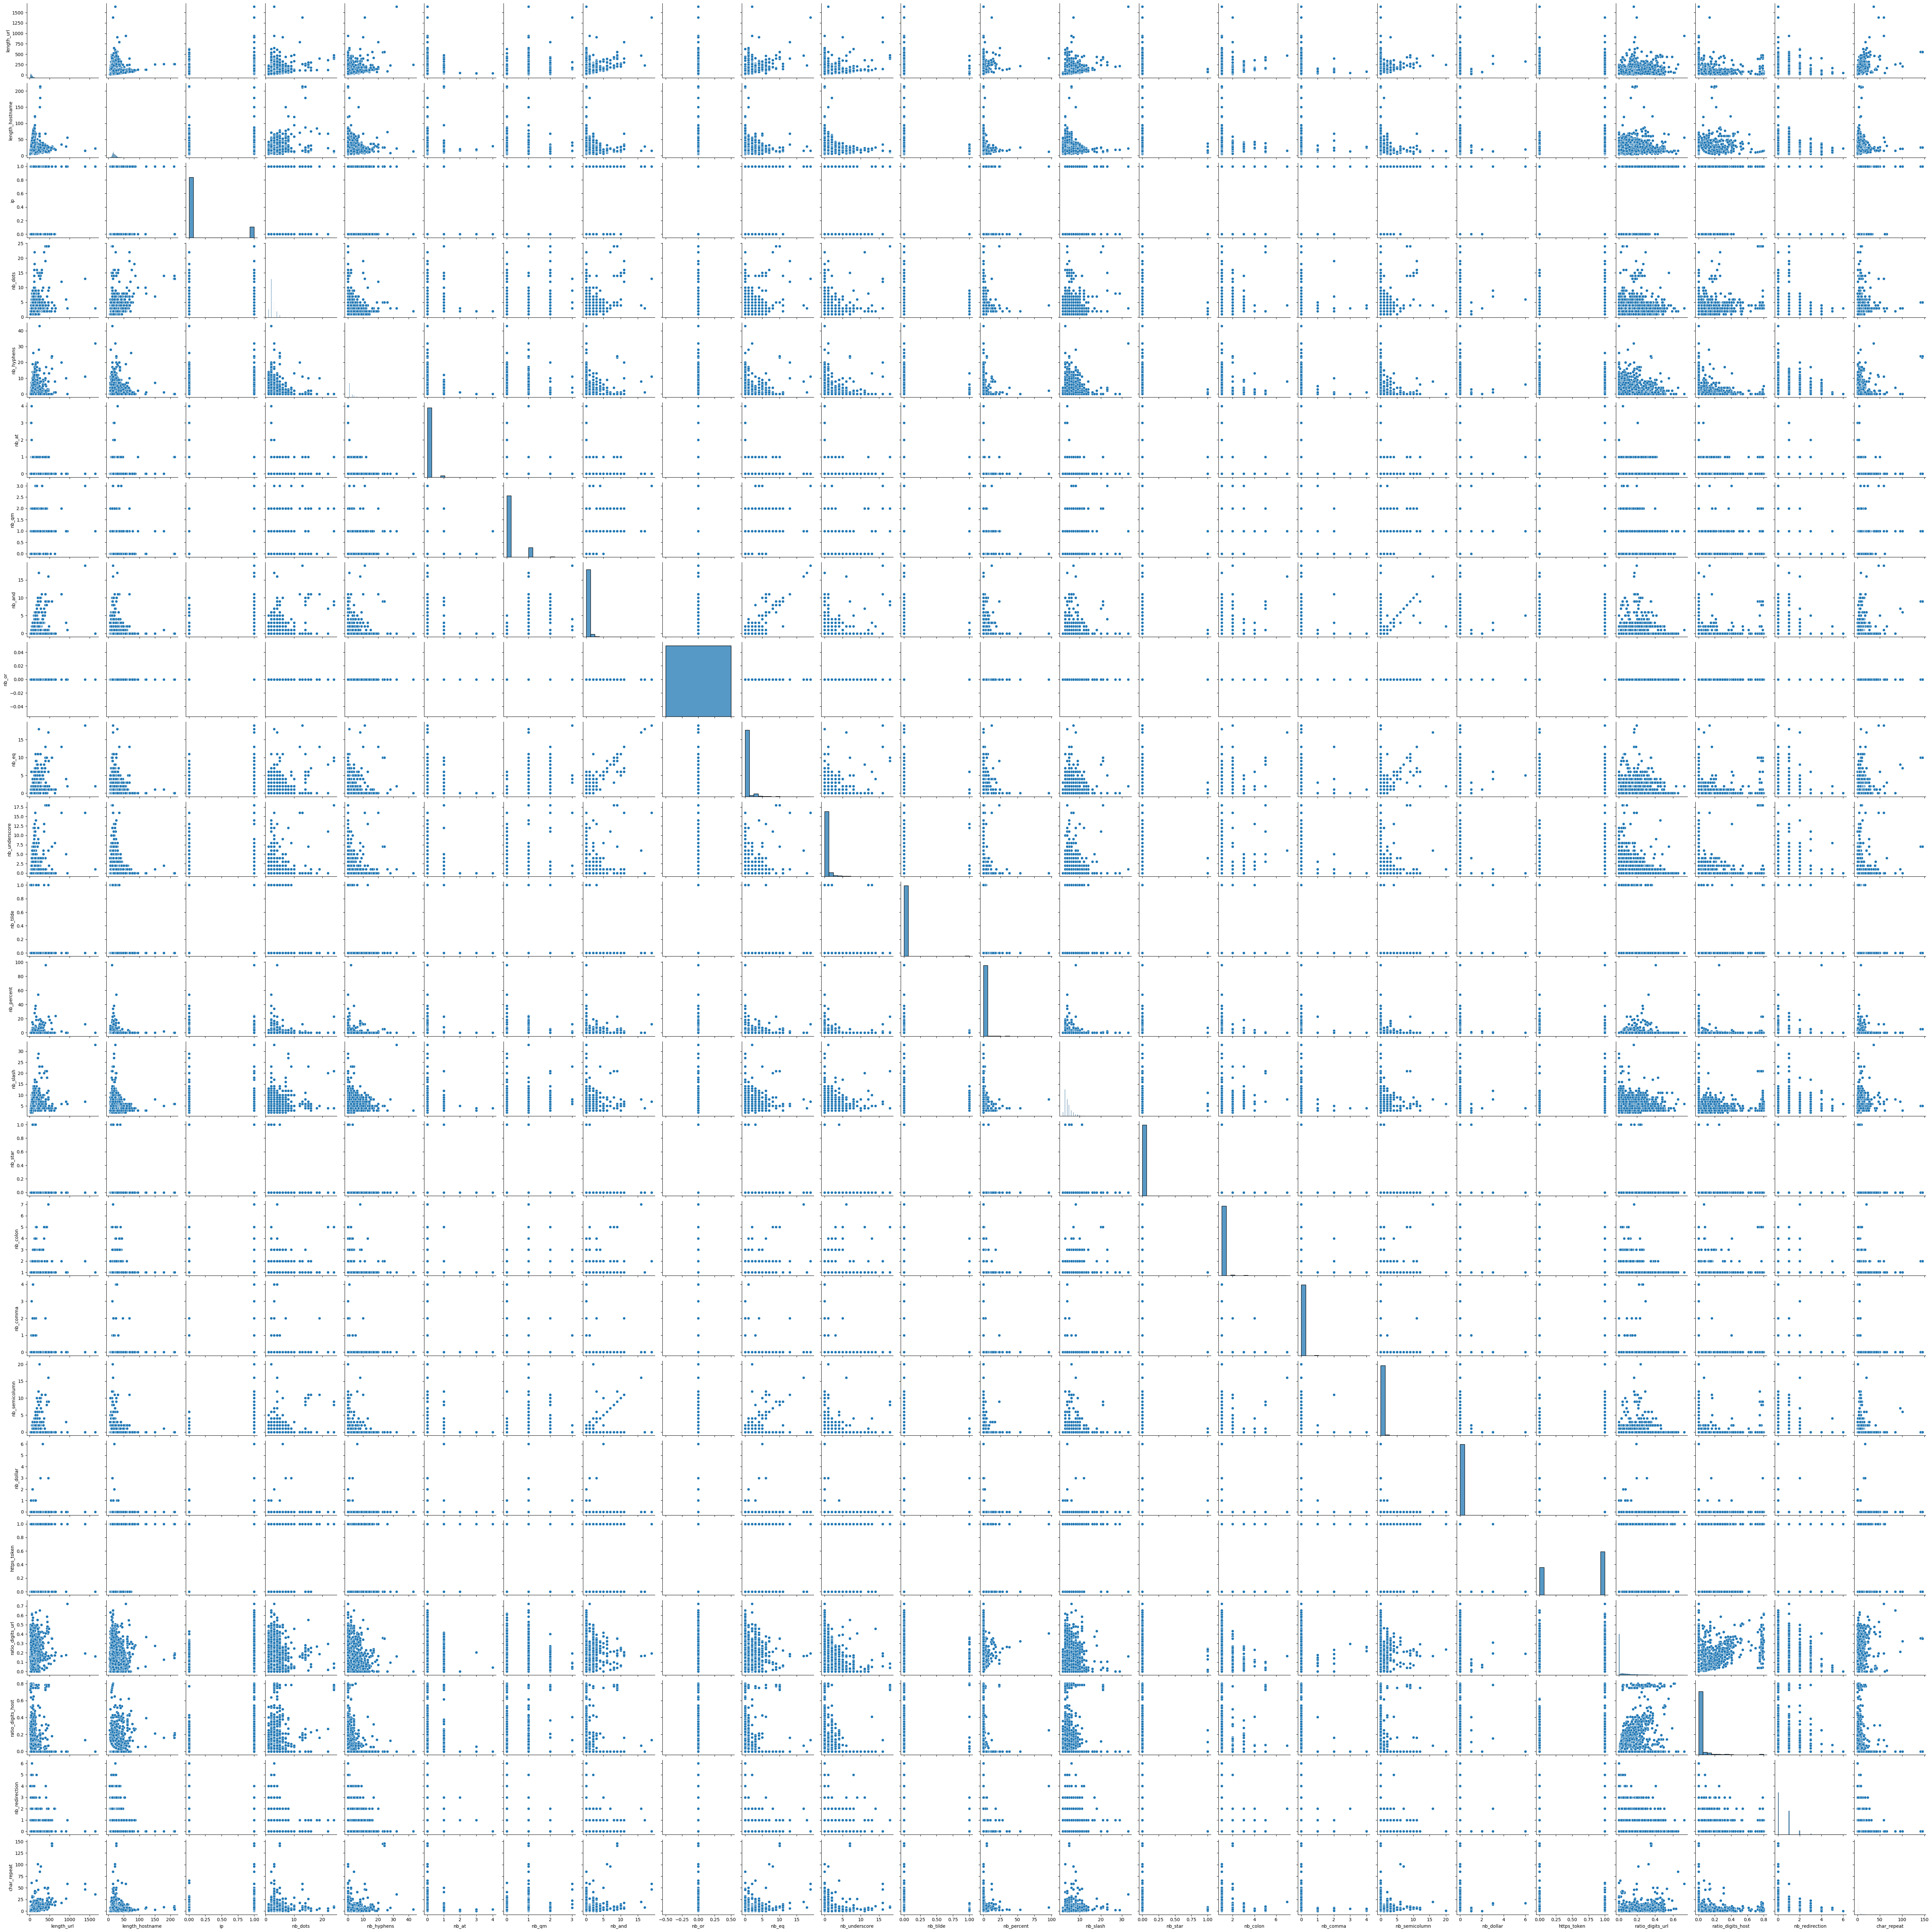

In [97]:
sns.pairplot(phishing_webpage_features)
None

In [98]:
interesting_features = phishing_webpage_features[['length_url', 'length_hostname', 'nb_hyphens', 'ratio_digits_url', 'ratio_digits_host', 'char_repeat']]

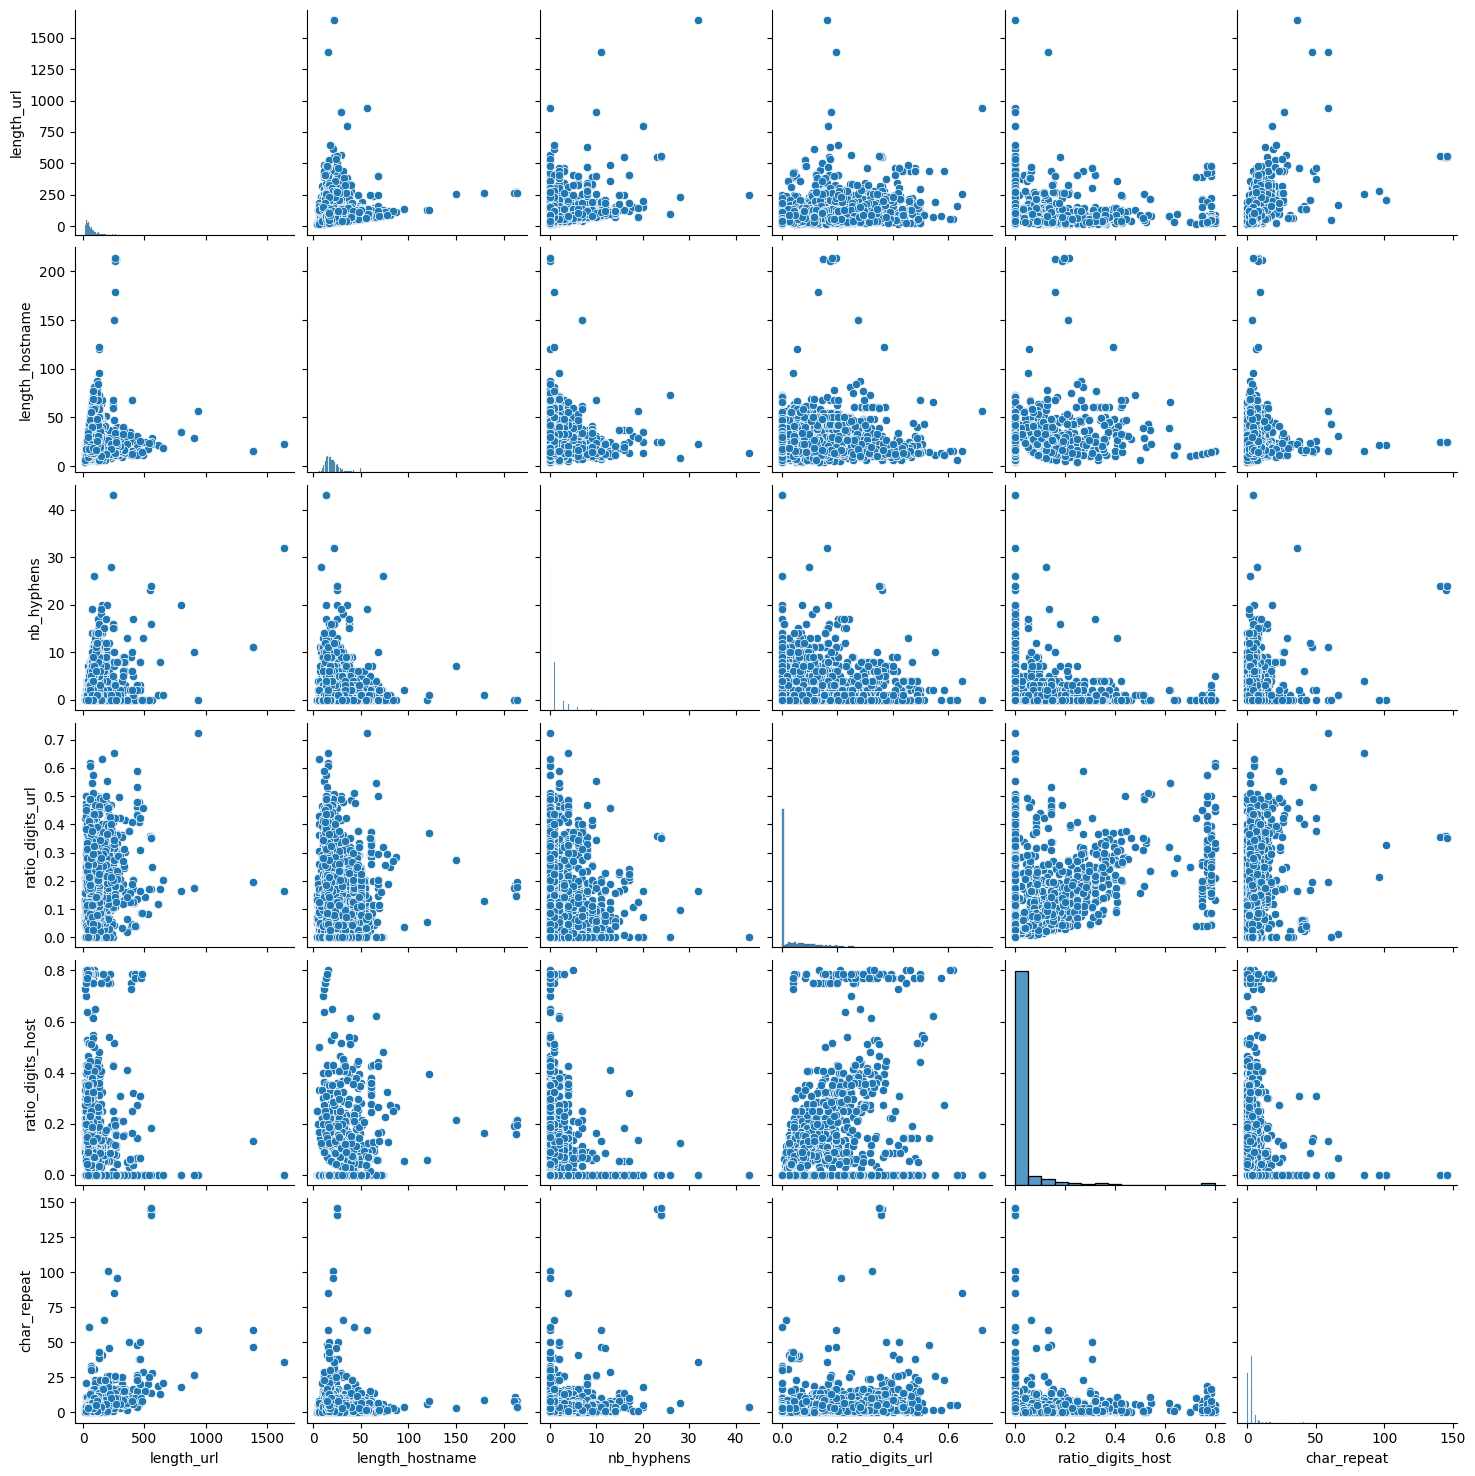

In [99]:
_ = sns.pairplot(interesting_features)

### Dataset 2: Phishing Email Detection

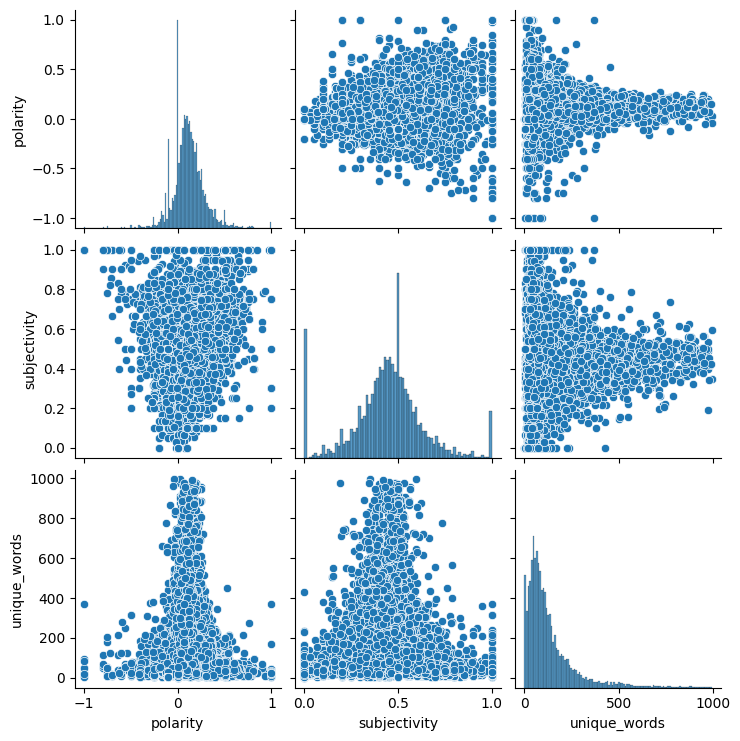

In [100]:
sns.pairplot(df_email[['polarity', 'subjectivity', 'unique_words']].query('unique_words < 1000'))
None

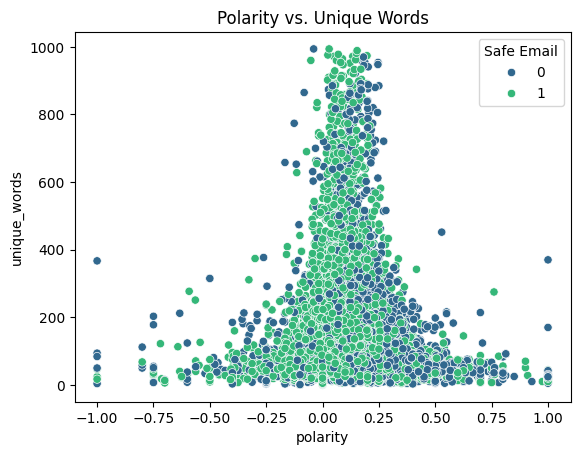

In [101]:
sns.scatterplot(
    data=df_email[['unique_words', 'polarity', 'Safe Email']].query('unique_words < 1000'),
    y='unique_words',
    x='polarity',
    hue='Safe Email',
    palette='viridis',
)
plt.title('Polarity vs. Unique Words')
None

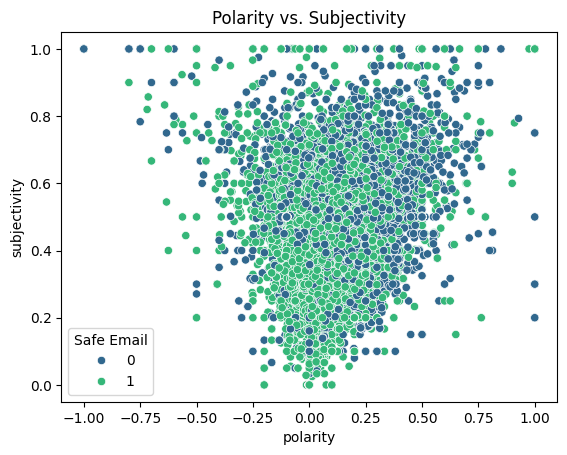

In [102]:
sns.scatterplot(
    data=df_email[['polarity', 'subjectivity', 'Safe Email']],
    y='subjectivity',
    x='polarity',
    hue='Safe Email',
    palette='viridis',
)
plt.title('Polarity vs. Subjectivity')
None

### Dataset 3: Credit Card Transactions Fraud Detection Dataset

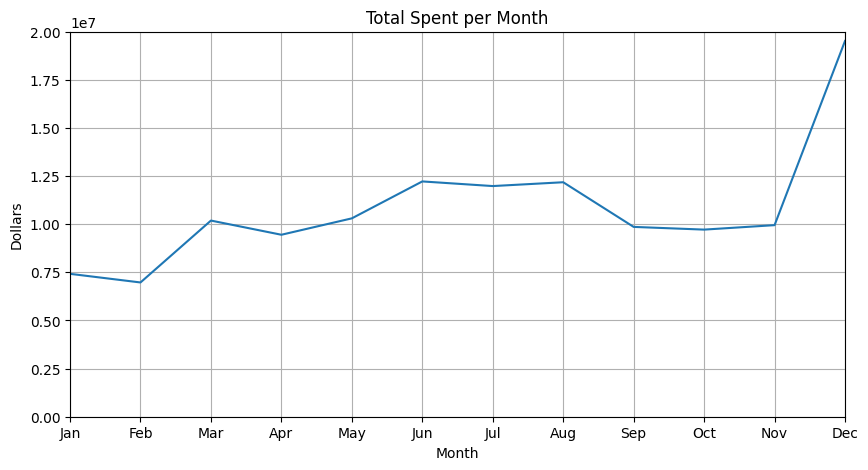

In [103]:
bymonth = credit_card.groupby(credit_card['trans_date_trans_time'].dt.month)['amt'].sum()
bymonth.plot.line(figsize=(10, 5), legend=False)
plt.title('Total Spent per Month')
plt.xlim(1, 12)
plt.ylim(0,2e7)
plt.xlabel('Month')
plt.ylabel('Dollars')
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
None

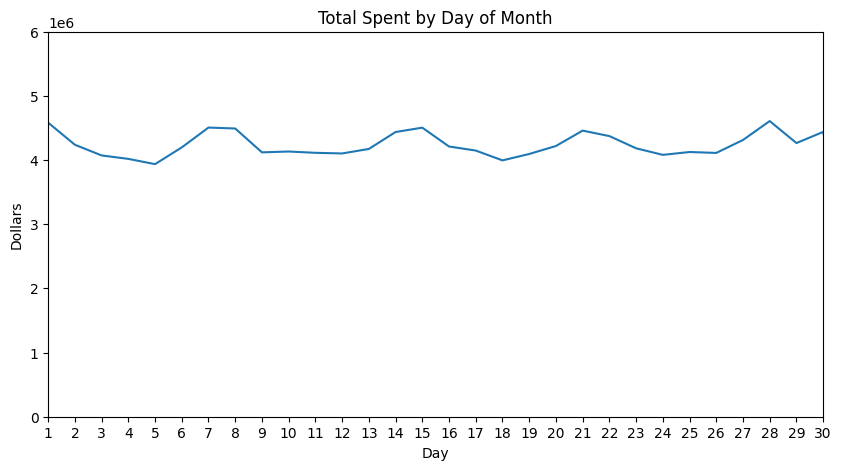

In [104]:
byday=credit_card.groupby(credit_card['trans_date_trans_time'].dt.day)['amt'].sum()
byday.plot.line(figsize=(10, 5), legend=False)
plt.title('Total Spent by Day of Month')
plt.xlim(1, 12)
plt.ylim(0, 0.6e7)
plt.xlabel('Day')
plt.ylabel('Dollars')
plt.xticks(ticks=range(1,31))
None

## Multivariant Analysis

### Functions

In [68]:
# Define the parameters for the Random Forest (Global Variable)

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
}

In [69]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=5, n_jobs=-1, confusion=False, **model_params):

    # Remove extra key used to store error metric, if it was added to the parameter dictionary
    if 'accuracy_found' in model_params:
        model_params = model_params.copy()
        model_params.pop('accuracy_found', None)  
    
    # Instantiate model if class is passed
    if isinstance(model, type):
        model = model(**model_params)
    else:
        model.set_params(**model_params)

    # Cross-validation setup
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    
    # Fit model on full training set
    model.fit(X_train, y_train)
    
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Metrics
    results = {
        "mean_cv_accuracy": np.mean(cv_scores),
        "std_cv_accuracy": np.std(cv_scores),
        "train_accuracy": accuracy_score(y_train, train_preds),
        "test_accuracy": accuracy_score(y_test, test_preds),
    }

    # Optionally add confusion matrices
    if confusion:
        results["confusion_train"] = confusion_matrix(y_train, train_preds)
        results["confusion_test"] = confusion_matrix(y_test, test_preds)

    return results

In [70]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    verbose          = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 5
                   ):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_accuracies, std_cvs, train_accuracies, test_accuracies = [], [], [], []
    no_improve_count = 0
    best_accuracy = -np.inf  # since higher accuracy is better
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove accuracy_found if present, just in case
        P_temp.pop('accuracy_found', None)
        
        # run_model updated to return: dictionary with
        # mean_cv_accuracy, std_cv_accuracy, train_accuracy, test_accuracy
        results = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_accuracies.append(results["mean_cv_accuracy"])
        std_cvs.append(results["std_cv_accuracy"])
        train_accuracies.append(results["train_accuracy"])
        test_accuracies.append(results["test_accuracy"])
        
        # Early-stopping logic: maximize accuracy
        if results["mean_cv_accuracy"] > best_accuracy + delta:
            best_accuracy = results["mean_cv_accuracy"]
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    max_cv_accuracy = max(cv_accuracies)
    max_index = cv_accuracies.index(max_cv_accuracy)
    best_param = parameter_list[max_index]
    Parameters[param] = best_param
    Parameters['accuracy_found'] = max_cv_accuracy
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # Use only as many parameter values as computed
        partial_param_list = parameter_list[:len(cv_accuracies)]
        
        # Check if our parameter list is Boolean for proper labeling
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        # ----- First plot: Accuracy -----
        ax1.set_title(f"Accuracy vs {param}")
        
        ax1.plot(x_vals,
                 cv_accuracies,
                 marker='.', label="CV Accuracy", color='blue')
        ax1.plot(x_vals,
                 train_accuracies,
                 marker='.', label="Train Accuracy", color='green')
        ax1.plot(x_vals,
                 test_accuracies,
                 linestyle='--', label="Test Accuracy", color='orange')
        ax1.scatter([x_vals[max_index]],
                    [max_cv_accuracy],
                    marker='x', label="Best CV Accuracy", color='red')
        
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Standard Deviation -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label="CV Accuracy Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


In [71]:
def format_time(seconds):
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

In [72]:
def grid_search(model, X_train, y_train, X_test, y_test, param_grid, n_repeats=5):
    # Record start time
    start = time.time()

    # Use GridSearchCV to find the best parameters
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=RepeatedStratifiedKFold(n_repeats=n_repeats, random_state=42),
        n_jobs=-1,
        return_train_score=True
    )

    # Fit the GridSearchCV
    search.fit(X_train, y_train)

    # Best parameters and test performance
    print(f"\nBest Parameters: {search.best_params_}")
    print(f"Cross-Validation Accuracy: {search.best_score_:.4f}")

    # Compute training and testing accuracy
    train_preds    = search.best_estimator_.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = search.best_estimator_.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Record end time and execution time
    end = time.time()
    print(f"Execution Time: " + format_time(end-start))

    return search, results

In [73]:
def random_search(model, X_train, y_train, X_test, y_test, param_grid, n_iter=50, n_repeats=5):
    # Record start time
    start = time.time()

    # Use randomized search to find the best parameters
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='accuracy',
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=42),
        n_jobs=-1,
        return_train_score=True,
        random_state=42
    )

    # Fit the GridSearchCV
    search.fit(X_train, y_train)

    # Best parameters and test performance
    print(f"\nBest Parameters: {search.best_params_}")
    print(f"Cross-Validation Accuracy: {search.best_score_:.4f}")

    # Compute training and testing accuracy
    train_preds    = search.best_estimator_.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_preds     = search.best_estimator_.predict(X_test)
    test_accuracy  = accuracy_score(y_test, test_preds)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Extract results into a DataFrame
    results = pd.DataFrame(search.cv_results_)

    # Record end time and execution time
    end = time.time()
    print(f"Execution Time: " + format_time(end-start))

    return search, results

In [74]:
def print_sweep(model, X_train, y_train, X_test, y_test, RF_Param_ranges, n_repeats=5):
    # Make a copy of the default parameters dictionary
    Parameters_RF_baseline = Default_Parameters_Random_Forests.copy()

    # Define empty param list for storing
    RF_Param_BT_list = []

    for (param, parameter_list) in RF_Param_ranges:
        RF_Param_BT = sweep_parameter(model,
                                      Parameters_RF_baseline,
                                      param,
                                      parameter_list,
                                      X_train,
                                      y_train,
                                      X_test,
                                      y_test,
                                      n_repeats = n_repeats
                                      )

        print(f"\nParameter {param} = {RF_Param_BT[param]} Accuracy = {RF_Param_BT['accuracy_found']*100:.2f}%\n")
        print(RF_Param_BT)

        # Store best parameters and show in dataframe
        RF_Param_BT_list.append(RF_Param_BT)

    results = pd.DataFrame(RF_Param_BT_list)

    return results

In [75]:
# Check values in dataframe are numeric
def check_numeric(df):
    numeric_test = df.dtypes.apply(lambda dtype: np.issubdtype(dtype, np.number)).all()
    if numeric_test:
        print('All values are numeric.')
    else:
        raise ValueError("DataFrame contains non-numeric values.")

### Dataset 1: Web Page Phishing Detection

In [113]:
# Separate target/features for modeling
X1 = df_webpage.drop(columns=['legitimate'])
y1 = df_webpage['legitimate']

# Check numeric
check_numeric(df_webpage)

# Create train/test split
X_train_wp, X_test_wp, y_train_wp, y_test_wp = train_test_split(X1, y1, test_size=0.2, random_state=42)

All values are numeric.


In [114]:
# Apply scaling to train and test set
scaler1 = StandardScaler()
X_train_wp_scaled = scaler1.fit_transform(X_train_wp)
X_test_wp_scaled = scaler1.transform(X_test_wp)

PCA Explained Variance Ratio:
[0.1014822  0.05365723 0.04760601]


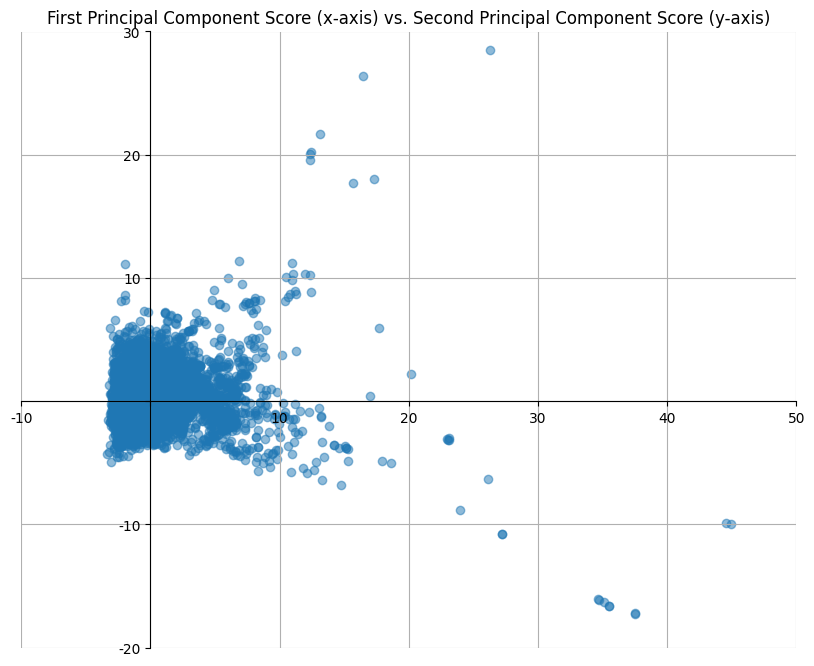

In [115]:
# Perform PCA on training data
pca1 = decomposition.PCA(n_components = 3)
pca1.fit(X_train_wp_scaled)
print('PCA Explained Variance Ratio:')
print(pca1.explained_variance_ratio_)

# Plot First and Second principal components to look for outliers
fig, ax = plt.subplots(figsize=(10, 8))
first_principal_component_score_1 = X_train_wp_scaled.dot(pca1.components_[0]) # Projection of data onto PC1
second_principal_component_score_1 = X_train_wp_scaled.dot(pca1.components_[1]) # Projection of data onto PC2
ax.scatter(first_principal_component_score_1, second_principal_component_score_1, alpha=0.5)
ax.set_title("First Principal Component Score (x-axis) vs. Second Principal Component Score (y-axis)")

# Set axis limits
ax.set_xlim([-10, 50])
ax.set_ylim([-20, 30])

# Move axes to center (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Hide the top and right spines
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Set ticks only on bottom and left
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Remove the 0 labels for reading clarity
xticks = ax.get_xticks()
xtick_labels = ["" if tick == 0 else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

yticks = ax.get_yticks()
ytick_labels = ["" if tick == 0 else str(int(tick)) for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

# Show plot and adjust grid
plt.grid(True)
plt.show()

In [116]:
# Baseline model before tuning
BL_results_1 = run_model(RandomForestClassifier(),
                         X_train_wp_scaled,
                         y_train_wp,
                         X_test_wp_scaled,
                         y_test_wp,
                         n_repeats=5,
                         n_jobs=-1,
                         **Default_Parameters_Random_Forests
                        )

In [117]:
print('Baseline Model Metrics:')
print(f"Mean CV Accuracy: {BL_results_1['mean_cv_accuracy']:.4f}")
print(f"Std CV Accurcy: {BL_results_1['std_cv_accuracy']:.4f}")
print(f"Train Accuracy: {BL_results_1['train_accuracy']:.4f}")
print(f"Test Accuracy: {BL_results_1['test_accuracy']:.4f}")

Baseline Model Metrics:
Mean CV Accuracy: 0.9565
Std CV Accurcy: 0.0049
Train Accuracy: 1.0000
Test Accuracy: 0.9571


In [120]:
# Check how many features
print(f'There are a total of {len(X_train_wp.columns)} features.')

There are a total of 87 features.


Sweeping n_estimators: 100%|██████████| 10/10 [07:42<00:00, 46.24s/it]


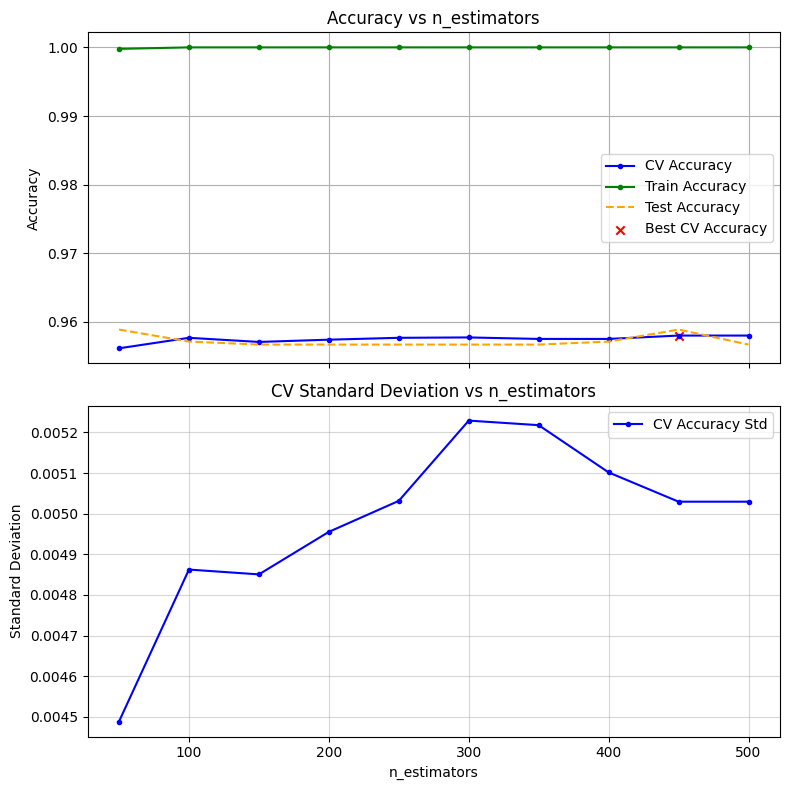

Execution Time: 00:07:42

Parameter n_estimators = 450 Accuracy = 95.80%

{'n_estimators': 450, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9580058335616431}
Sweeping max_features: 100%|██████████| 43/43 [06:08<00:00,  8.58s/it]


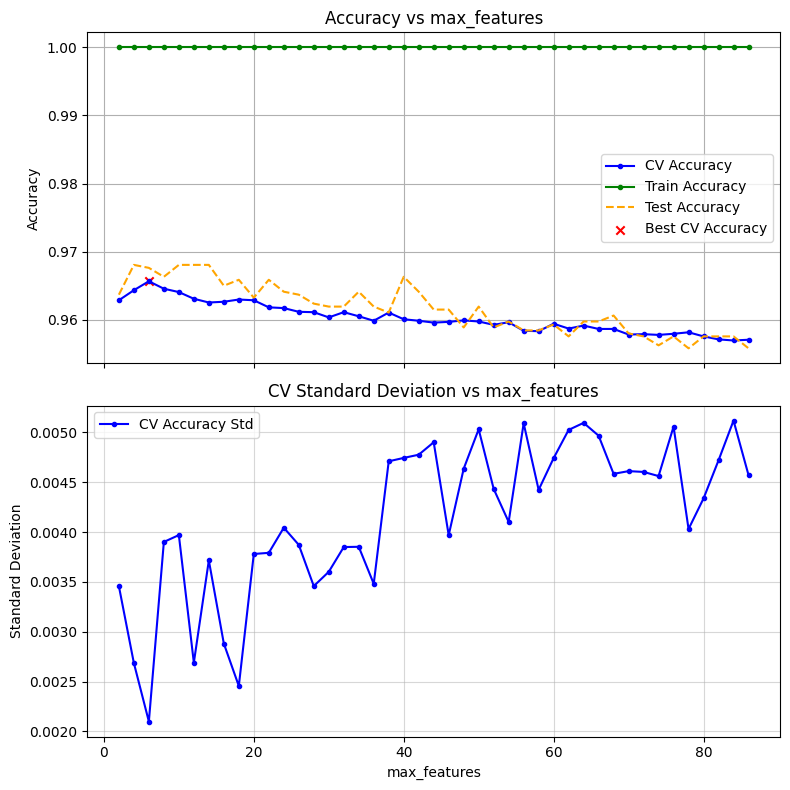

Execution Time: 00:06:09

Parameter max_features = 6 Accuracy = 96.57%

{'n_estimators': 100, 'max_features': 6, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9656607082824372}
Sweeping max_depth: 100%|██████████| 28/28 [06:38<00:00, 14.22s/it]


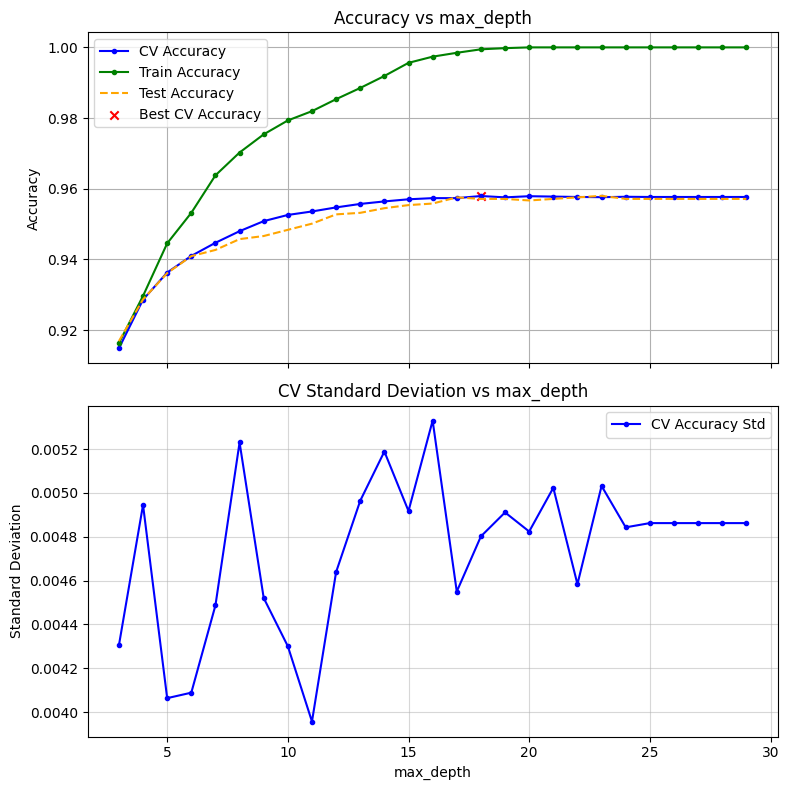

Execution Time: 00:06:38

Parameter max_depth = 18 Accuracy = 95.80%

{'n_estimators': 100, 'max_features': None, 'max_depth': 18, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9579512186951533}
Sweeping min_samples_split: 100%|██████████| 9/9 [02:31<00:00, 16.82s/it]


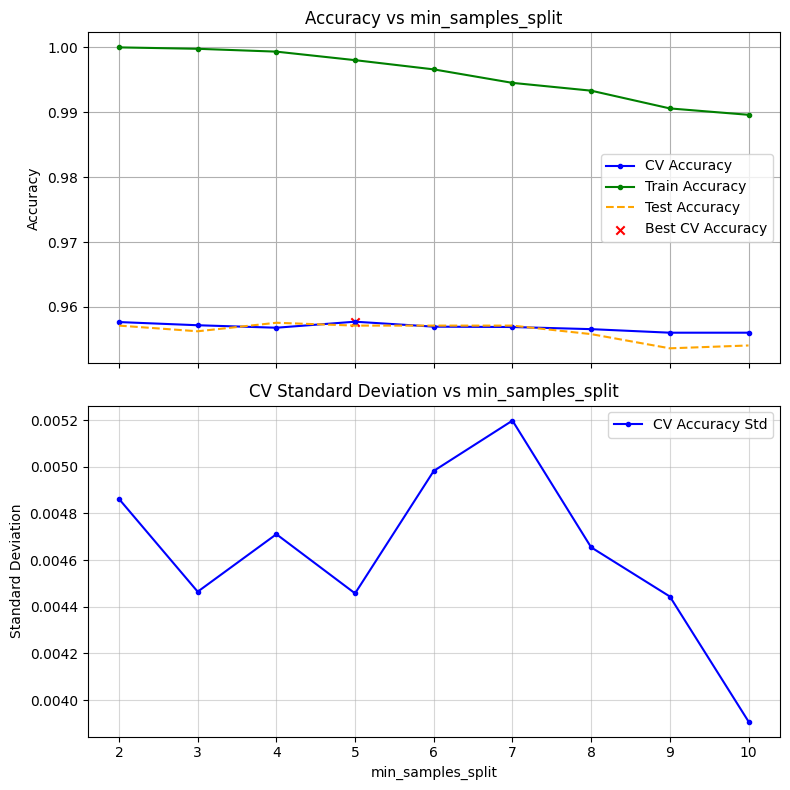

Execution Time: 00:02:31

Parameter min_samples_split = 5 Accuracy = 95.77%

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'min_samples_split': 5, 'accuracy_found': 0.9577324302239749}


In [120]:
# First sweep parameters (n_repeats=2)
RF_Param_ranges_1a = [('n_estimators', range(50, 501, 50)),
                    ('max_features', range(2, 88, 2)),
                    ('max_depth', [None]+ list(range(3, 30))),
                    ('min_samples_split', range(2, 11))
                    ]

model_1a = RandomForestClassifier(random_state=42)

results_1a = print_sweep(model_1a, X_train_wp_scaled, y_train_wp, X_test_wp_scaled, y_test_wp, RF_Param_ranges_1a, n_repeats=2)

Sweeping n_estimators: 100%|██████████| 20/20 [38:16<00:00, 114.85s/it]


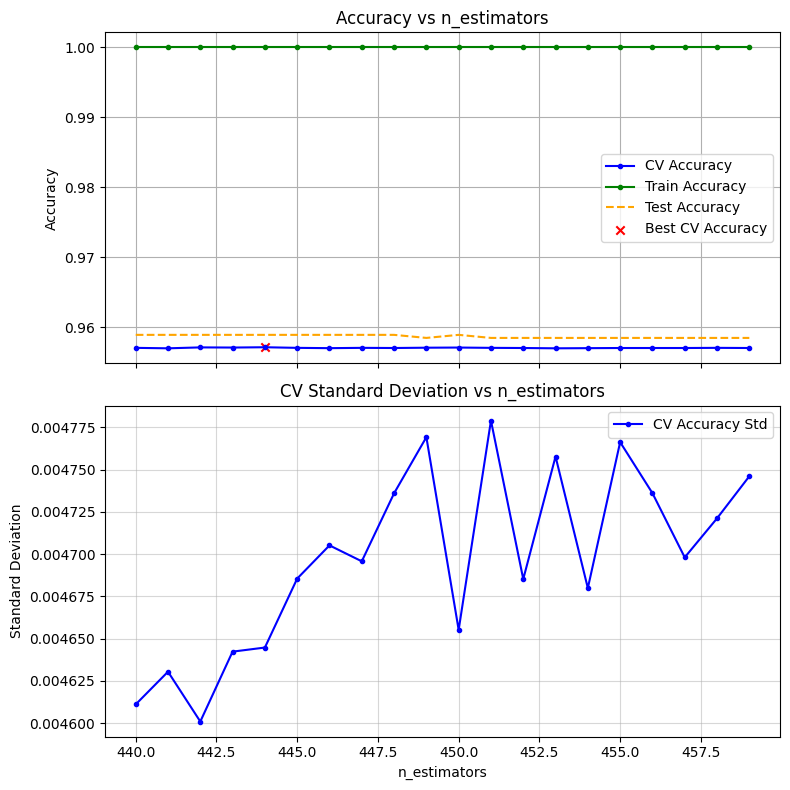

Execution Time: 00:38:17

Parameter n_estimators = 444 Accuracy = 95.71%

{'n_estimators': 444, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9571088217665068}
Sweeping max_features: 100%|██████████| 8/8 [00:21<00:00,  2.63s/it]


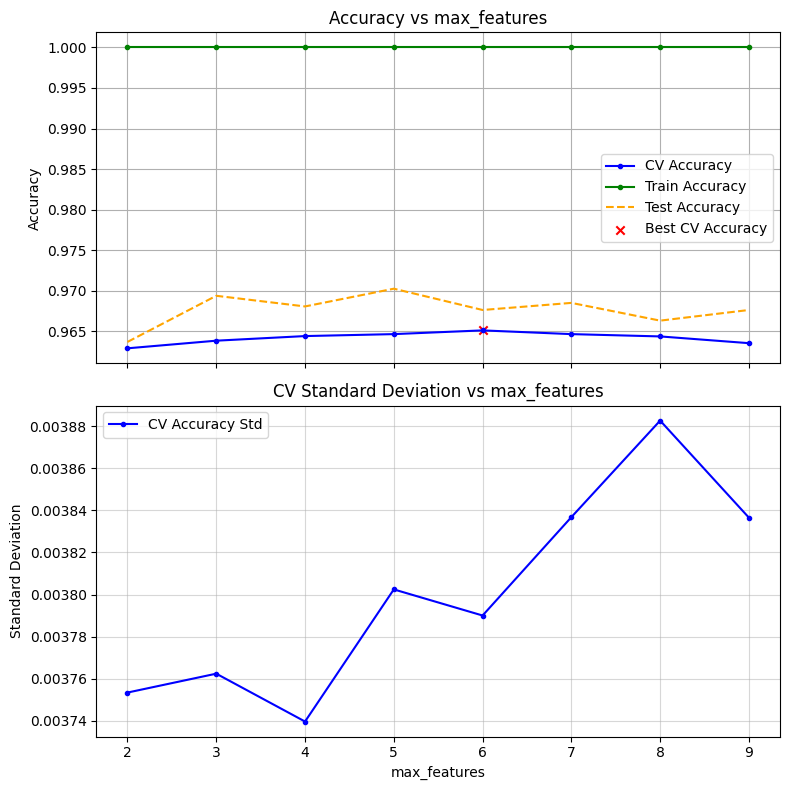

Execution Time: 00:00:21

Parameter max_features = 6 Accuracy = 96.51%

{'n_estimators': 100, 'max_features': 6, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.965113913570927}
Sweeping max_depth: 100%|██████████| 11/11 [04:42<00:00, 25.65s/it]


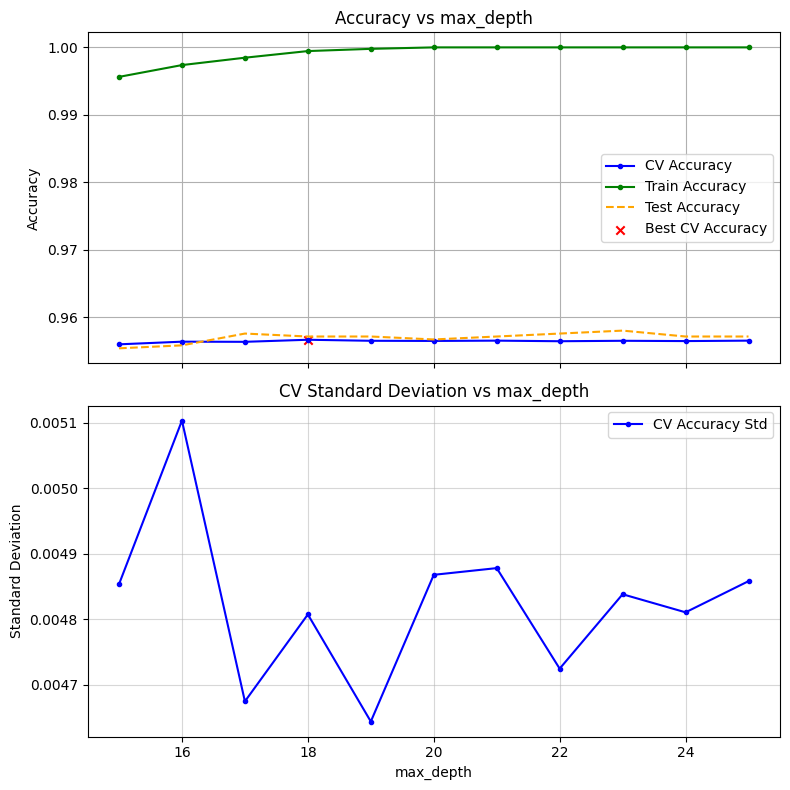

Execution Time: 00:04:42

Parameter max_depth = 18 Accuracy = 95.66%

{'n_estimators': 100, 'max_features': None, 'max_depth': 18, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9566495663711204}
Sweeping min_samples_split: 100%|██████████| 6/6 [02:34<00:00, 25.75s/it]


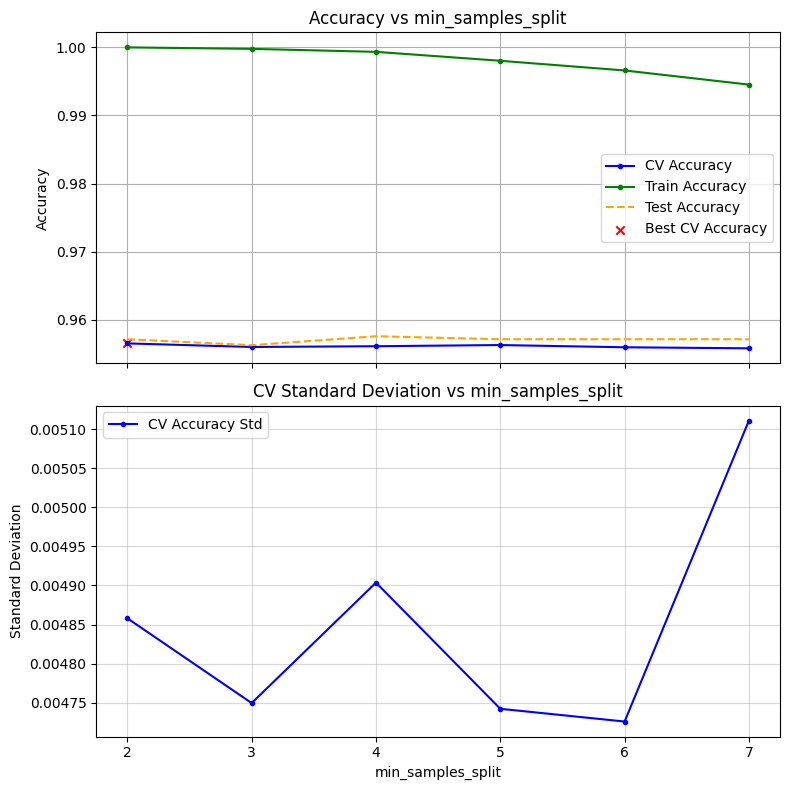

Execution Time: 00:02:34

Parameter min_samples_split = 2 Accuracy = 95.65%

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'min_samples_split': 2, 'accuracy_found': 0.9565183471256309}


In [124]:
# Second sweep parameters to finetune (n_repeats=5)
RF_Param_ranges_1b = [('n_estimators', range(440, 460)),
                    ('max_features', range(2, 10)),
                    ('max_depth', range(15, 26)),
                    ('min_samples_split', range(2, 8))
                    ]

model_1b = RandomForestClassifier(random_state=42)

results1b = print_sweep(model_1b, X_train_wp_scaled, y_train_wp, X_test_wp_scaled, y_test_wp, RF_Param_ranges_1b, n_repeats=5)

In [123]:
# Define the model
RF_model_1c = RandomForestClassifier(random_state=42)

# Define the parameter grid
RF_param_grid_1c = {
    'n_estimators': range(420, 461),       
    'max_features' : [None] + list(range(4, 8)),
    'max_depth': [None] + list(range(20, 31)),
    'min_samples_split': range(2, 8)
}

# Randomized search
search_1c, result_1c = random_search(RF_model_1c, X_train_wp_scaled, y_train_wp, X_test_wp_scaled, y_test_wp, RF_param_grid_1c)


Best Parameters: {'n_estimators': 444, 'min_samples_split': 3, 'max_features': 5, 'max_depth': 26}
Cross-Validation Accuracy: 0.9657
Train Accuracy: 1.0000
Test Accuracy: 0.9681
Execution Time: 44m 32.20s


In [126]:
# Run best model
best_results_1 = run_model(RandomForestClassifier(),
                           X_train_wp_scaled,
                           y_train_wp,
                           X_test_wp_scaled,
                           y_test_wp,
                           n_repeats=5,
                           n_jobs=-1,
                           confusion=True,
                           **search_1c.best_params_
                           )

In [130]:
# Print results
print('Best Model Metrics: Webpage Phishing Detection')
print(f"Mean CV Accuracy: {best_results_1['mean_cv_accuracy']:.4f}")
print(f"Std CV Accurcy: {best_results_1['std_cv_accuracy']:.4f}")
print(f"Train Accuracy: {best_results_1['train_accuracy']:.4f}")
print(f"Test Accuracy: {best_results_1['test_accuracy']:.4f}")

Best Model Metrics: Webpage Phishing Detection
Mean CV Accuracy: 0.9651
Std CV Accurcy: 0.0035
Train Accuracy: 1.0000
Test Accuracy: 0.9663


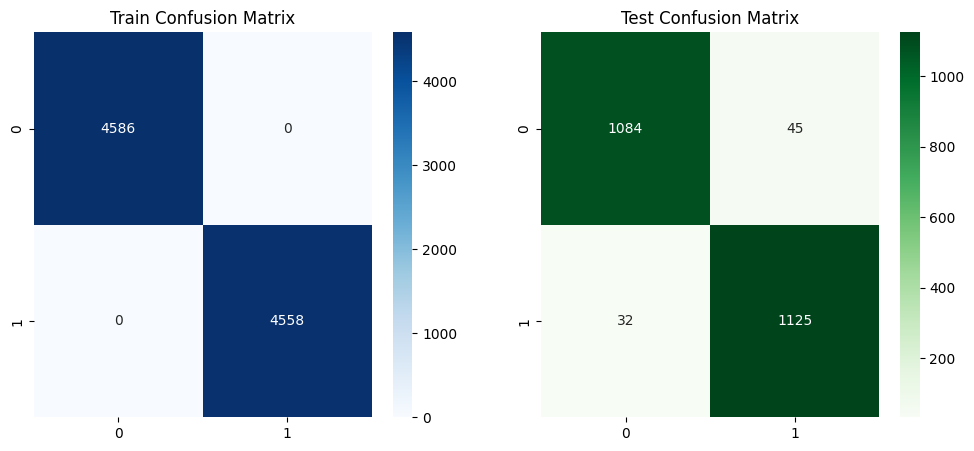

In [133]:
# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(best_results_1['confusion_train'], annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Train Confusion Matrix")
sns.heatmap(best_results_1['confusion_test'], annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
plt.show()

### Dataset 2: Phishing Email Detection

In [136]:
# Separate target/features for modeling
X2 = df_email.drop(columns=['Safe Email'])
y2 = df_email['Safe Email']

# Check numeric
check_numeric(df_email)
                                  
# Create train/test split
X_train_email, X_test_email, y_train_email, y_test_email = train_test_split(X2, y2, test_size=0.2, random_state=42)

All values are numeric.


In [139]:
# Apply scaling to train and test set
scaler2 = StandardScaler()
X_train_email_scaled = scaler2.fit_transform(X_train_email)
X_test_email_scaled = scaler2.transform(X_test_email)

PCA Explained Variance Ratio:
[0.20434076 0.08723153 0.06924518]


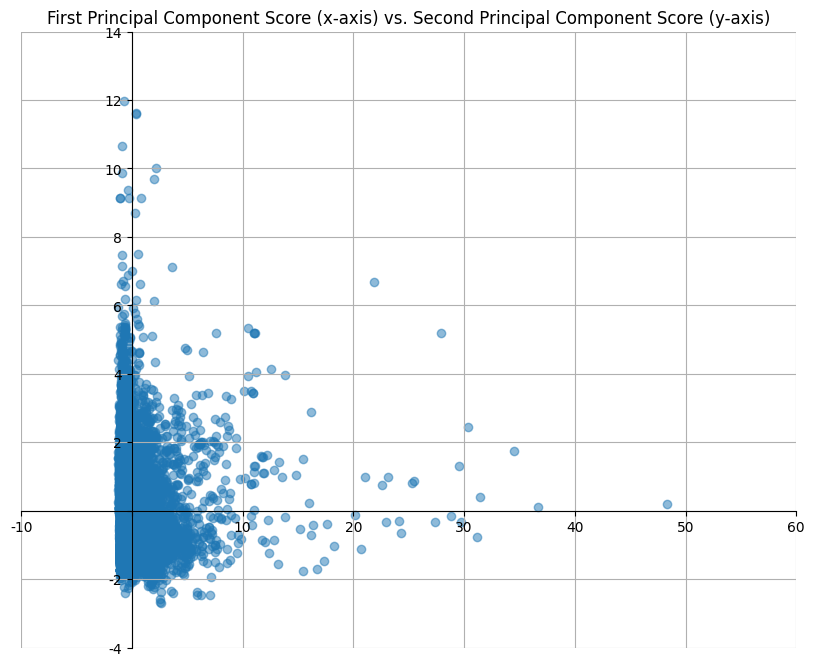

In [142]:
# Perform PCA on training data
pca2 = decomposition.PCA(n_components = 3)
pca2.fit(X_train_email_scaled)
print('PCA Explained Variance Ratio:')
print(pca2.explained_variance_ratio_)

# Plot First and Second principal components to look for outliers
fig, ax = plt.subplots(figsize=(10, 8))
first_principal_component_score_2 = X_train_email_scaled.dot(pca2.components_[0]) # Projection of data onto PC1
second_principal_component_score_2 = X_train_email_scaled.dot(pca2.components_[1]) # Projection of data onto PC2
ax.scatter(first_principal_component_score_2, second_principal_component_score_2, alpha=0.5)
ax.set_title("First Principal Component Score (x-axis) vs. Second Principal Component Score (y-axis)")

# Move axes to center (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Hide the top and right spines
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Set ticks only on bottom and left
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Remove the 0 labels for reading clarity
xticks = ax.get_xticks()
xtick_labels = ["" if tick == 0 else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

yticks = ax.get_yticks()
ytick_labels = ["" if tick == 0 else str(int(tick)) for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

# Show plot and adjust grid
plt.grid(True)
plt.show()

In [145]:
# Baseline model before tuning
BL_results_2 = run_model(RandomForestClassifier(),
                         X_train_email_scaled,
                         y_train_email,
                         X_test_email_scaled,
                         y_test_email,
                         n_repeats=5,
                         n_jobs=-1,
                         **Default_Parameters_Random_Forests
                        )

In [146]:
print('Baseline Model Metrics:')
print(f"Mean CV Accuracy: {BL_results_2['mean_cv_accuracy']:.4f}")
print(f"Std CV Accurcy: {BL_results_2['std_cv_accuracy']:.4f}")
print(f"Train Accuracy: {BL_results_2['train_accuracy']:.4f}")
print(f"Test Accuracy: {BL_results_2['test_accuracy']:.4f}")

Baseline Model Metrics:
Mean CV Accuracy: 0.8397
Std CV Accurcy: 0.0072
Train Accuracy: 0.9891
Test Accuracy: 0.8426


In [147]:
# Check how many features
print(f'There are a total of {len(X_train_email.columns)} features.')

There are a total of 17 features.


Sweeping n_estimators: 100%|██████████| 10/10 [08:08<00:00, 48.84s/it]


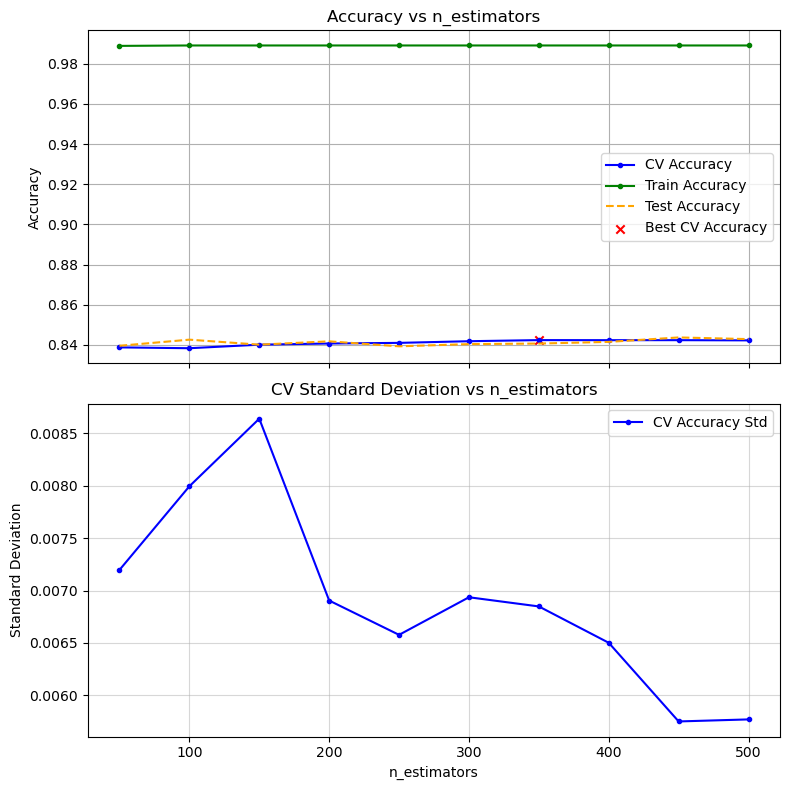

Execution Time: 00:08:08

Parameter n_estimators = 350 Accuracy = 84.23%

{'n_estimators': 350, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.8423382912487029}


Sweeping max_features: 100%|██████████| 8/8 [01:25<00:00, 10.74s/it]


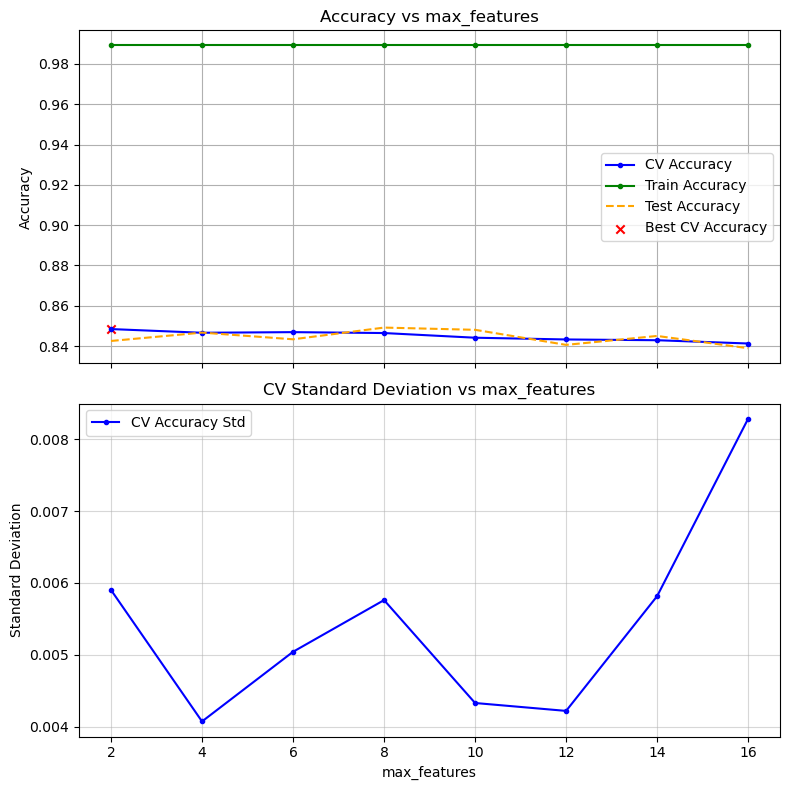

Execution Time: 00:01:26

Parameter max_features = 2 Accuracy = 84.85%

{'n_estimators': 100, 'max_features': 2, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.8484607402282947}


Sweeping max_depth: 100%|██████████| 10/10 [02:26<00:00, 14.63s/it]


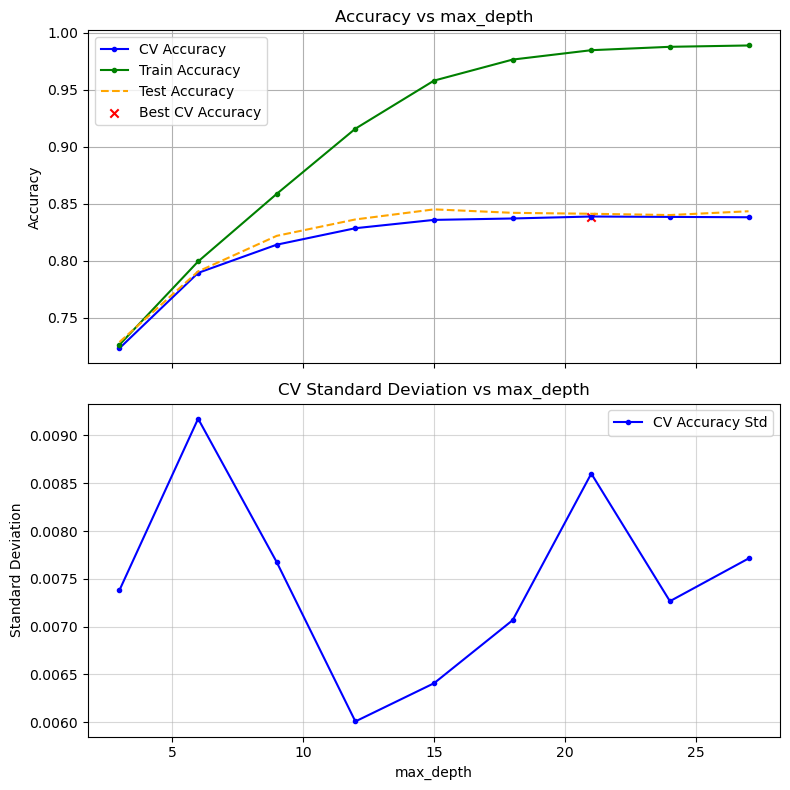

Execution Time: 00:02:26

Parameter max_depth = 21 Accuracy = 83.88%

{'n_estimators': 100, 'max_features': None, 'max_depth': 21, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.8387755102040815}


Sweeping min_samples_split: 100%|██████████| 9/9 [02:36<00:00, 17.36s/it]


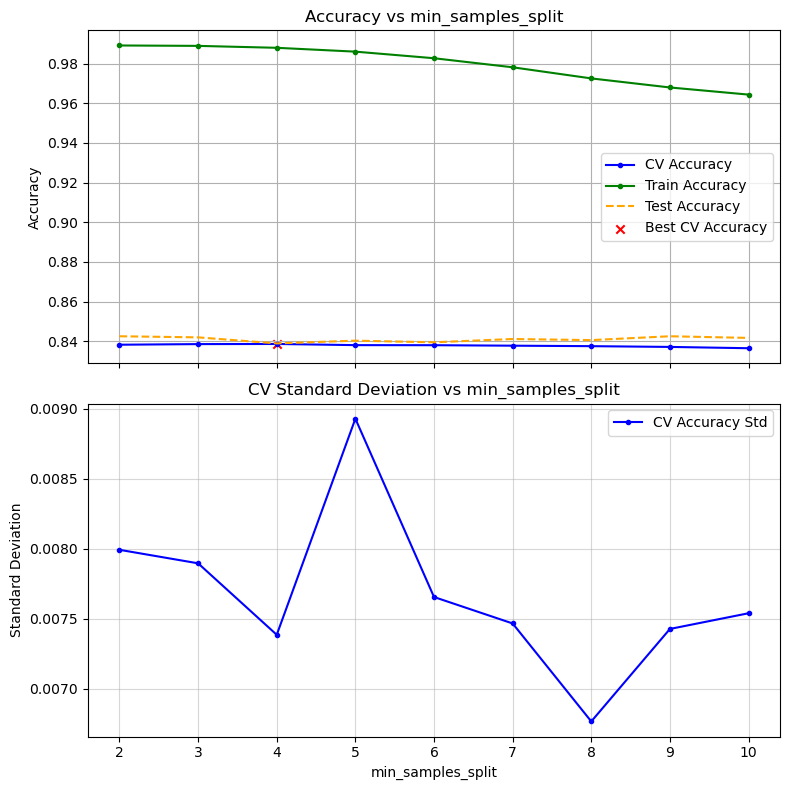

Execution Time: 00:02:36

Parameter min_samples_split = 4 Accuracy = 83.87%

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'min_samples_split': 4, 'accuracy_found': 0.8386717398823936}


In [119]:
# First sweep parameters (n_repeats=2)
RF_Param_ranges_2a = [('n_estimators', range(50, 501, 50)),
                    ('max_features', range(2, 18, 2)),
                    ('max_depth', [None]+ list(range(3, 30, 3))),
                    ('min_samples_split', range(2, 11))
                    ]

model_2a = RandomForestClassifier(random_state=42)

results_2a = print_sweep(model_2a, X_train_email_scaled, y_train_email, X_test_email_scaled, y_test_email, RF_Param_ranges_2a, n_repeats=2)

Sweeping n_estimators: 100%|██████████| 6/6 [13:52<00:00, 138.75s/it]


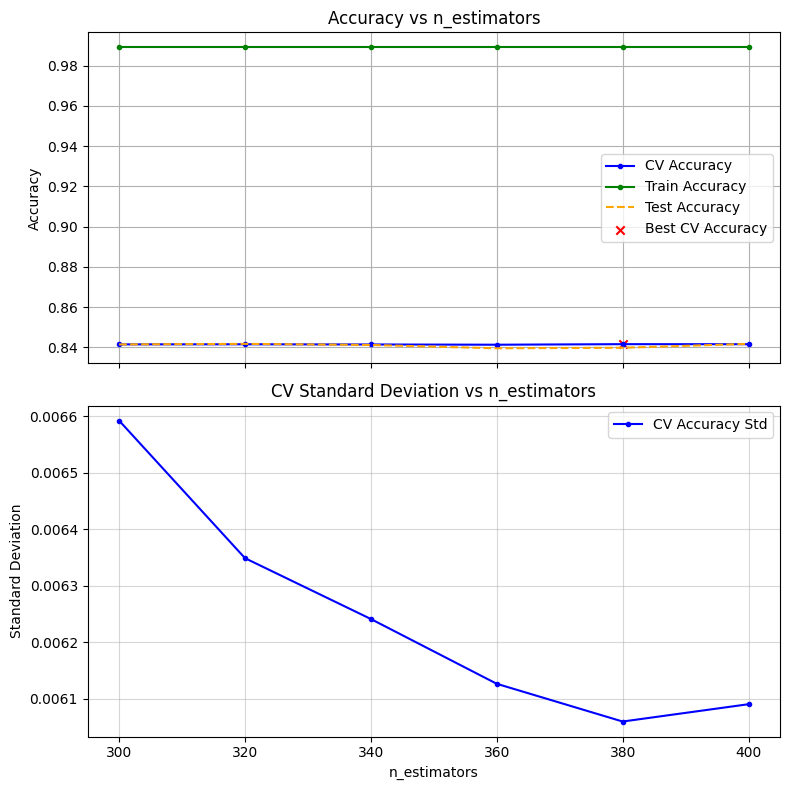

Execution Time: 00:13:52

Parameter n_estimators = 380 Accuracy = 84.16%

{'n_estimators': 380, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.8415773088896575}
Sweeping max_features: 100%|██████████| 8/8 [02:00<00:00, 15.06s/it]


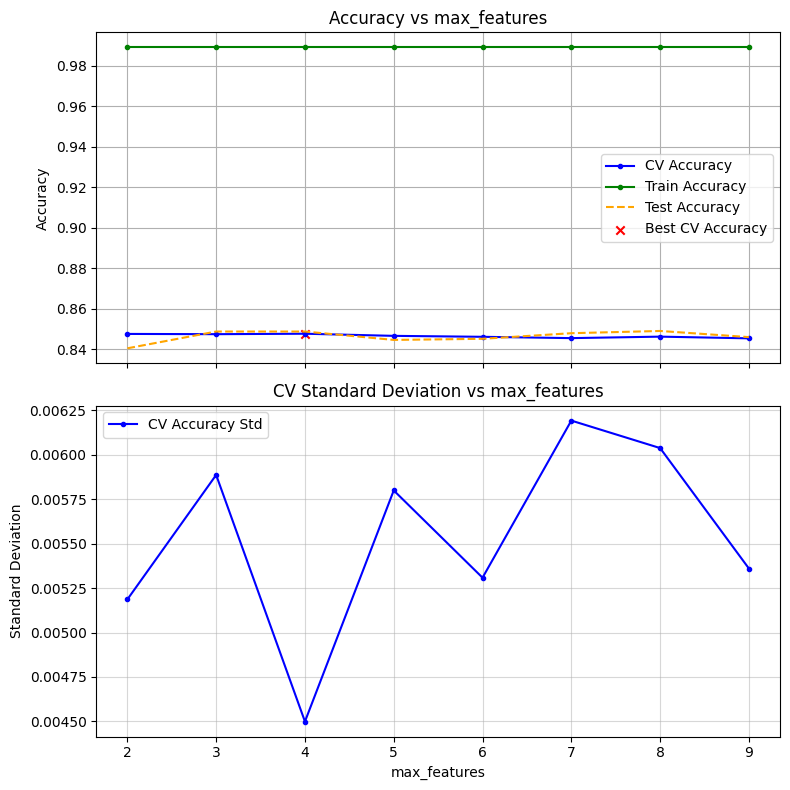

Execution Time: 00:02:00

Parameter max_features = 4 Accuracy = 84.76%

{'n_estimators': 100, 'max_features': 4, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.8475544794188863}
Sweeping max_depth: 100%|██████████| 10/10 [06:27<00:00, 38.78s/it]


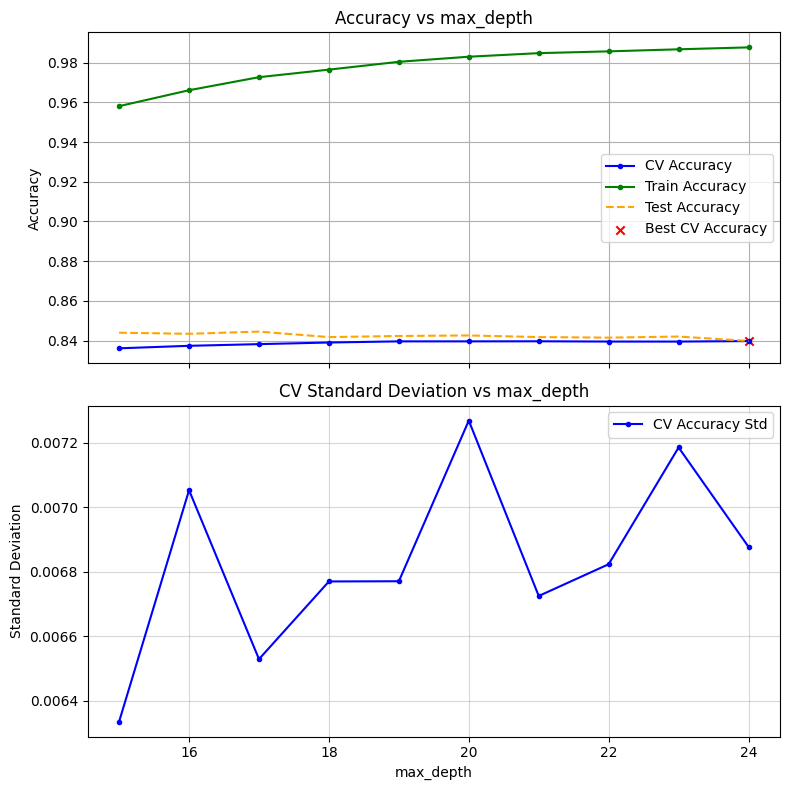

Execution Time: 00:06:28

Parameter max_depth = 24 Accuracy = 83.97%

{'n_estimators': 100, 'max_features': None, 'max_depth': 24, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.8397232791421655}
Sweeping min_samples_split: 100%|██████████| 6/6 [03:57<00:00, 39.52s/it]


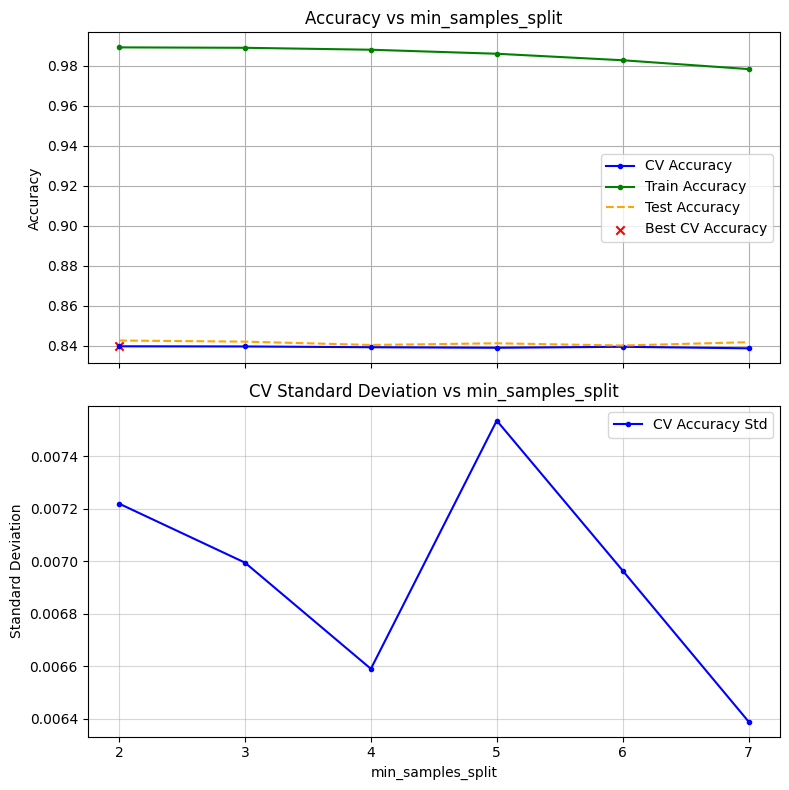

Execution Time: 00:03:57

Parameter min_samples_split = 2 Accuracy = 83.97%

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'min_samples_split': 2, 'accuracy_found': 0.8396679349705984}


In [156]:
# Second sweep parameters to finetune (n_repeats=5)
RF_Param_ranges_2b = [('n_estimators', range(300, 401, 20)),
                    ('max_features', range(2, 10)),
                    ('max_depth', range(15, 25)),
                    ('min_samples_split', range(2, 8))
                    ]

model_2b = RandomForestClassifier(random_state=42)

results_2b = print_sweep(model_2b, X_train_email_scaled, y_train_email, X_test_email_scaled, y_test_email, RF_Param_ranges_2b, n_repeats=5)

In [159]:
# Define the model
RF_model_2c = RandomForestClassifier(random_state=42)

# Define the parameter grid
RF_param_grid_2c = {
    'n_estimators': range(350, 381),       
    'max_features' : [None] + list(range(3, 8)),
    'max_depth': [None] + list(range(20, 31)),
    'min_samples_split': range(2, 5)
}

# Randomized Search (n_iters = 50)
search_2c, result_2c = random_search(RF_model_2c, X_train_email_scaled, y_train_email, X_test_email_scaled, y_test_email, RF_param_grid_2c)


Best Parameters: {'n_estimators': 380, 'min_samples_split': 3, 'max_features': 3, 'max_depth': 29}
Cross-Validation Accuracy: 0.8498
Train Accuracy: 0.9884
Test Accuracy: 0.8470
Execution Time: 41m 41.69s


In [160]:
# Run best model
best_results_2 = run_model(RandomForestClassifier(),
                           X_train_email_scaled,
                           y_train_email,
                           X_test_email_scaled,
                           y_test_email,
                           n_repeats=5,
                           n_jobs=-1,
                           confusion=True,
                           **search_2c.best_params_
                           )

In [161]:
# Print results
print('Best Model Metrics: Email Phishing Detection')
print(f"Mean CV Accuracy: {best_results_2['mean_cv_accuracy']:.4f}")
print(f"Std CV Accurcy: {best_results_2['std_cv_accuracy']:.4f}")
print(f"Train Accuracy: {best_results_2['train_accuracy']:.4f}")
print(f"Test Accuracy: {best_results_2['test_accuracy']:.4f}")

Best Model Metrics: Email Phishing Detection
Mean CV Accuracy: 0.8497
Std CV Accurcy: 0.0055
Train Accuracy: 0.9886
Test Accuracy: 0.8486


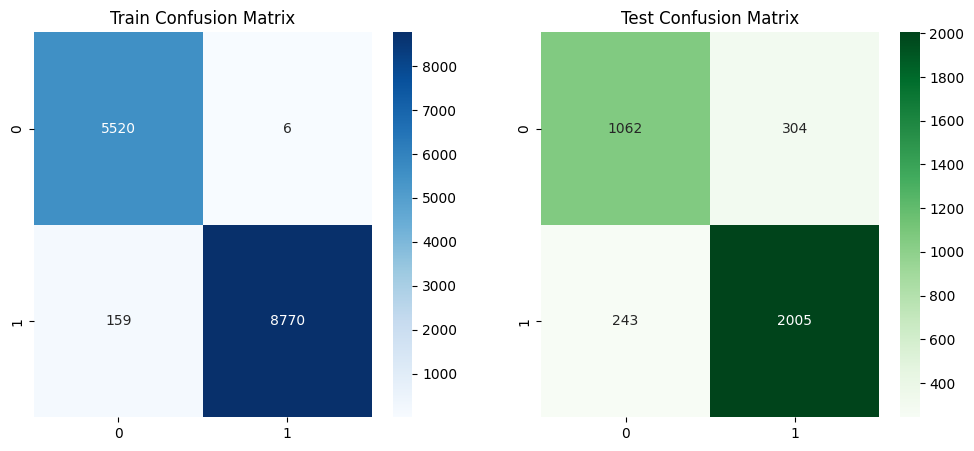

In [162]:
# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(best_results_2['confusion_train'], annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Train Confusion Matrix")
sns.heatmap(best_results_2['confusion_test'], annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
plt.show()

### Dataset 3: Credit Card Transactions Fraud Detection Dataset

In [81]:
# Check numeric
check_numeric(df_credit_card)

# Take a sample of the data (too many data points for preliminary work)
df_credit_card_sample = df_credit_card.sample(frac=0.1, random_state=42)
print(f'Sample size: {len(df_credit_card_sample)} datapoints')

# Separate target/features for modeling
X3 = df_credit_card_sample.drop(columns=['is_fraud'])
y3 = df_credit_card_sample['is_fraud']

                                  
# Create train/test split
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X3, y3, test_size=0.2, random_state=42)
print(f'Sample size: {len(X_train_credit)} datapoints')

All values are numeric.
Sample size: 185239 datapoints
Sample size: 148191 datapoints


In [84]:
# Apply scaling to train and test set
scaler3 = StandardScaler()
X_train_credit_scaled = scaler3.fit_transform(X_train_credit)
X_test_credit_scaled = scaler3.transform(X_test_credit)

PCA Explained Variance Ratio:
[0.16403001 0.14431769 0.11791656]


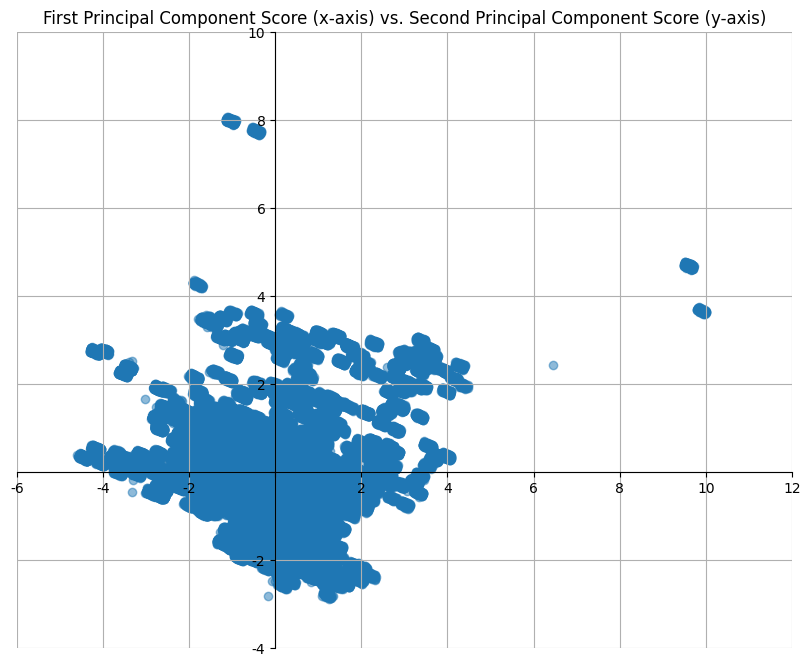

In [178]:
# Perform PCA on training data
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(X_train_credit_scaled)
print('PCA Explained Variance Ratio:')
print(pca3.explained_variance_ratio_)

# Plot First and Second principal components to look for outliers
fig, ax = plt.subplots(figsize=(10, 8))
first_principal_component_score_3 = X_train_credit_scaled.dot(pca3.components_[0]) # Projection of data onto PC1
second_principal_component_score_3 = X_train_credit_scaled.dot(pca3.components_[1]) # Projection of data onto PC2
ax.scatter(first_principal_component_score_3, second_principal_component_score_3, alpha=0.5)
ax.set_title("First Principal Component Score (x-axis) vs. Second Principal Component Score (y-axis)")

# Move axes to center (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

# Hide the top and right spines
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Set ticks only on bottom and left
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Remove the 0 labels for reading clarity
xticks = ax.get_xticks()
xtick_labels = ["" if tick == 0 else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

yticks = ax.get_yticks()
ytick_labels = ["" if tick == 0 else str(int(tick)) for tick in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

# Show plot and adjust grid
plt.grid(True)
plt.show()

In [181]:
# Baseline model before tuning
BL_results_3 = run_model(RandomForestClassifier(),
                         X_train_credit_scaled,
                         y_train_credit,
                         X_test_credit_scaled,
                         y_test_credit,
                         n_repeats=5,
                         n_jobs=-1,
                         **Default_Parameters_Random_Forests
                        )

In [182]:
print('Baseline Model Metrics:')
print(f"Mean CV Accuracy: {BL_results_3['mean_cv_accuracy']:.4f}")
print(f"Std CV Accurcy: {BL_results_3['std_cv_accuracy']:.4f}")
print(f"Train Accuracy: {BL_results_3['train_accuracy']:.4f}")
print(f"Test Accuracy: {BL_results_3['test_accuracy']:.4f}")

Baseline Model Metrics:
Mean CV Accuracy: 0.9973
Std CV Accurcy: 0.0002
Train Accuracy: 1.0000
Test Accuracy: 0.9978


In [183]:
# Check how many features
print(f'There are a total of {len(X_train_credit.columns)} features.')

There are a total of 14 features.


Sweeping n_estimators: 100%|██████████| 10/10 [1:52:56<00:00, 677.60s/it]


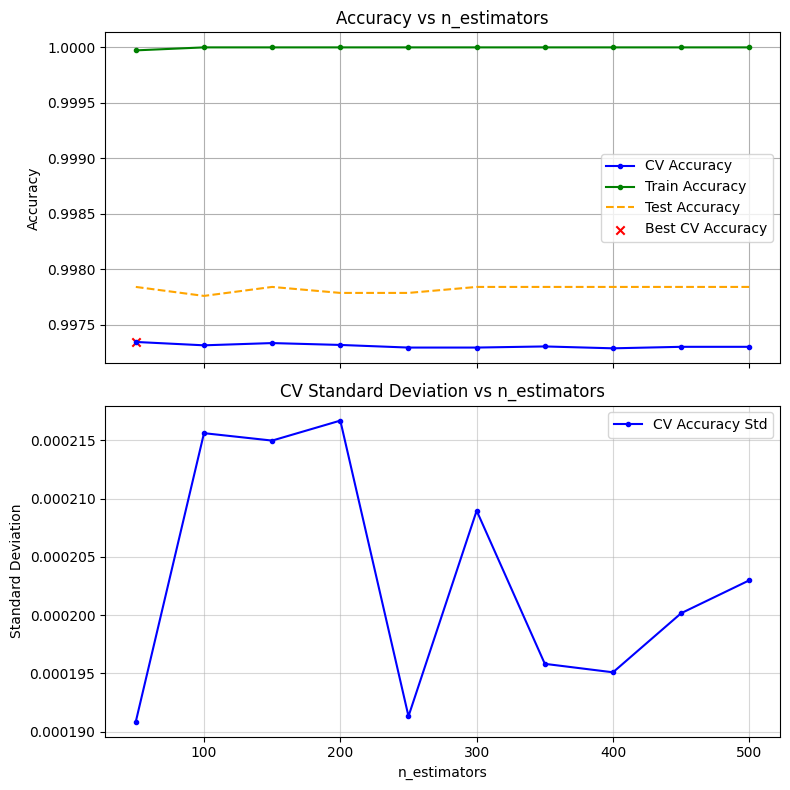

Execution Time: 01:52:56

Parameter n_estimators = 50 Accuracy = 99.73%

{'n_estimators': 50, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9973446442681941}
Sweeping max_features: 100%|██████████| 8/8 [22:00<00:00, 165.12s/it]


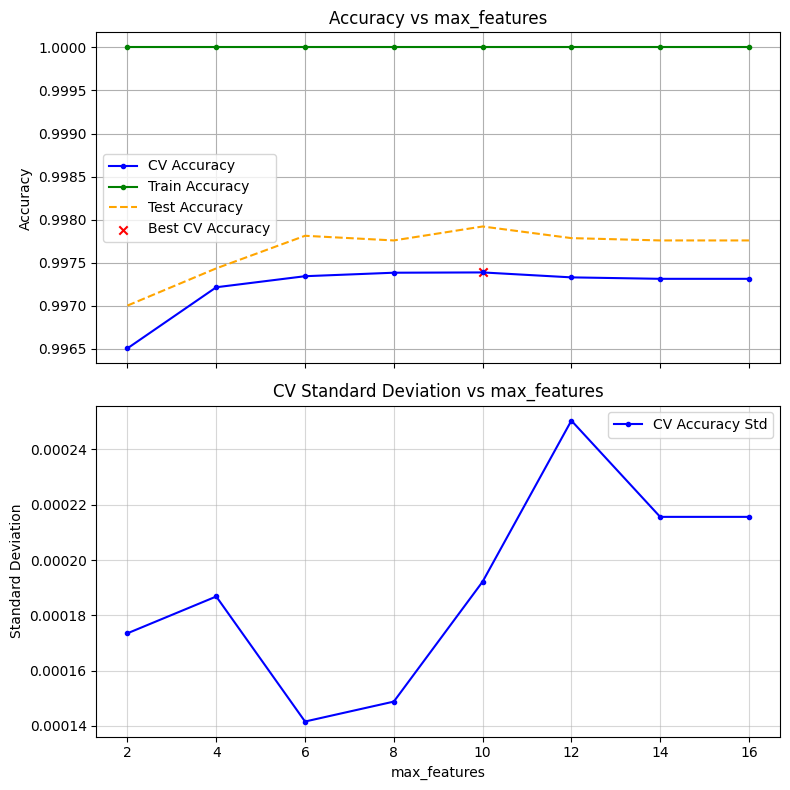

Execution Time: 00:22:01

Parameter max_features = 10 Accuracy = 99.74%

{'n_estimators': 100, 'max_features': 10, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9973885058524647}
Sweeping max_depth: 100%|██████████| 10/10 [35:25<00:00, 212.52s/it]


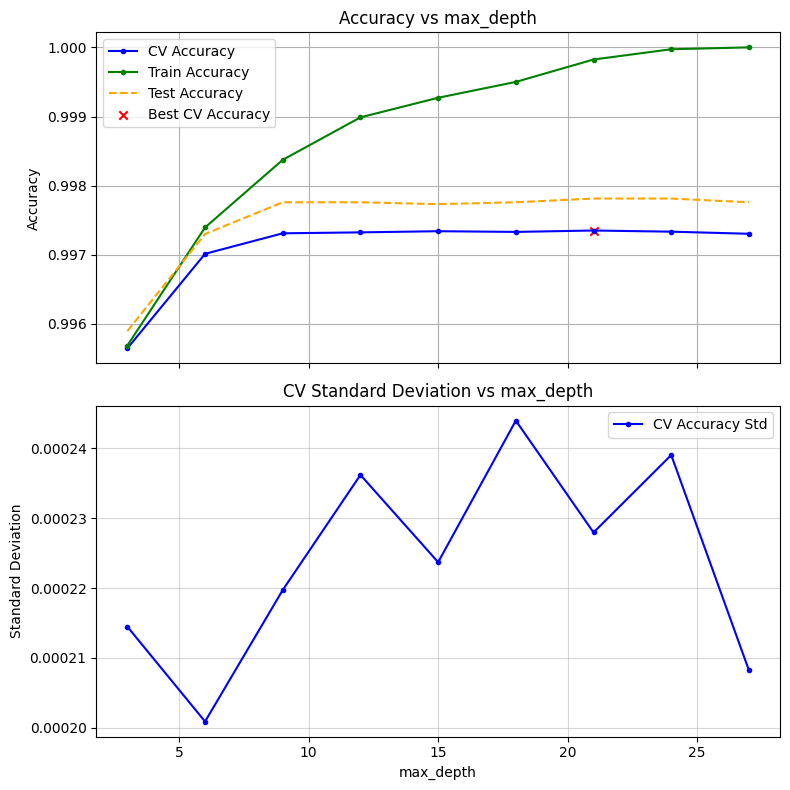

Execution Time: 00:35:25

Parameter max_depth = 21 Accuracy = 99.74%

{'n_estimators': 100, 'max_features': None, 'max_depth': 21, 'bootstrap': True, 'random_state': 42, 'accuracy_found': 0.9973513920203437}
Sweeping min_samples_split: 100%|██████████| 9/9 [36:28<00:00, 243.12s/it]


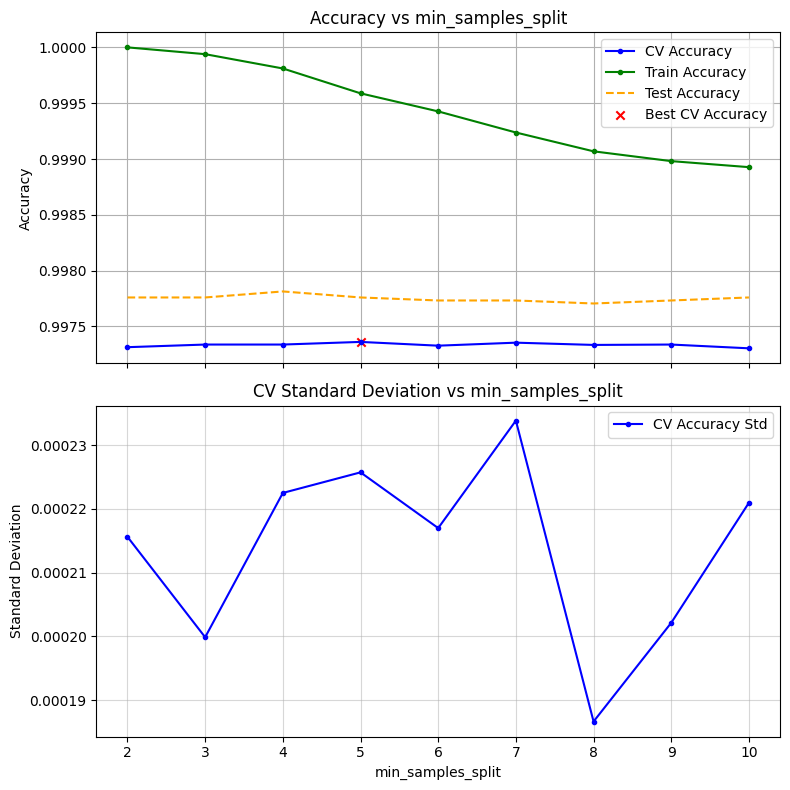

Execution Time: 00:36:28

Parameter min_samples_split = 5 Accuracy = 99.74%

{'n_estimators': 100, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'min_samples_split': 5, 'accuracy_found': 0.9973615137054865}


In [184]:
# First sweep parameters (n_repeats=2)
RF_Param_ranges_3a = [('n_estimators', range(50, 501, 50)),
                    ('max_features', range(2, 18, 2)),
                    ('max_depth', [None]+ list(range(3, 30, 3))),
                    ('min_samples_split', range(2, 11))
                    ]

model_3a = RandomForestClassifier(random_state=42)

results_3a = print_sweep(model_3a, X_train_credit_scaled, y_train_credit, X_test_credit_scaled, y_test_credit, RF_Param_ranges_3a, n_repeats=2)

In [87]:
# Define the model
RF_model_3b = RandomForestClassifier(random_state=42)

# Define the parameter grid
RF_param_grid_3b = {
    'n_estimators': range(50, 101),       
    'max_features' : [None] + list(range(5, 15)),
    'max_depth': [None] + list(range(20, 31)),
    'min_samples_split': range(2, 7)
}

# Randomized Search (n_iters = 10)
search_3b, result_3b = random_search(RF_model_3b, X_train_credit_scaled, y_train_credit, X_test_credit_scaled, y_test_credit, RF_param_grid_3b, n_iter=10)


Best Parameters: {'n_estimators': 94, 'min_samples_split': 3, 'max_features': 7, 'max_depth': None}
Cross-Validation Accuracy: 0.9974
Train Accuracy: 0.9999
Test Accuracy: 0.9979
Execution Time: 38m 2.04s


In [88]:
# Run best model
best_results_3 = run_model(RandomForestClassifier(),
                           X_train_credit_scaled,
                           y_train_credit,
                           X_test_credit_scaled,
                           y_test_credit,
                           n_repeats=5,
                           n_jobs=-1,
                           confusion=True,
                           **search_3b.best_params_
                           )

In [89]:
# Print results
print('Best Model Metrics: Credit Card Fraud Detection')
print(f"Mean CV Accuracy: {best_results_3['mean_cv_accuracy']:.4f}")
print(f"Std CV Accurcy: {best_results_3['std_cv_accuracy']:.4f}")
print(f"Train Accuracy: {best_results_3['train_accuracy']:.4f}")
print(f"Test Accuracy: {best_results_3['test_accuracy']:.4f}")

Best Model Metrics: Credit Card Fraud Detection
Mean CV Accuracy: 0.9974
Std CV Accurcy: 0.0002
Train Accuracy: 0.9999
Test Accuracy: 0.9979


In [90]:
# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(best_results_3['confusion_train'], annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Train Confusion Matrix")
sns.heatmap(best_results_3['confusion_test'], annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title("Test Confusion Matrix")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=18076b41-ad48-4025-9bc2-7264d8911ce3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>